# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'netifier-mc'
epochs = 10
batch_size = 32
sequence_length = 96

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/netifier-2/processed_train.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/netifier-2/processed_test.csv', encoding='latin-1')

data = pd.concat([train_data, val_data], ignore_index=True)
data.shape

(7773, 7)

In [7]:
data.head()

,original_text,source,pornografi,sara,radikalisme,pencemaran_nama_baik,processed_text
0,[QUOTE=jessepinkman16;5a50ac34d89b093f368b456e...,kaskus,0,0,0,1,jabar memang provinsi barokah boleh juga dan n...
1,"@verosvante kita2 aja nitizen yang pada kepo,t...",instagram,0,0,0,0,kita saja nitizen yang pada penasaran toh kelu...
2,"""#SidangAhok smg sipenista agama n ateknya mat...",twitter,0,1,1,1,sidangahok semoga sipenista agama dan ateknya ...
3,@bolususulembang.jkt barusan baca undang2 ini....,instagram,0,0,0,0,jakarta barusan baca undang ini tetap dibedaka...
4,bikin anak mulu lu nof \nkaga mikir apa kasian...,kaskus,0,0,0,0,buat anak melulu kamu nof nkaga mikir apa kasi...


In [8]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [9]:
train_labels = train_data.columns[2:6]
val_labels = val_data.columns[2:6]

# Extract features and labels for training and validation
X_train = train_data['processed_text'].values
y_train = train_data[train_labels].values
X_val = val_data['processed_text'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(6218,) (6218, 4)
(1555,) (1555, 4)


# BUILD DATASET & DATALOADERS

In [10]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import numpy as np
import torch

# Define custom Dataset class
class NetifierDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=96):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [11]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=96, num_workers=4):
    train_dataset = NetifierDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = NetifierDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [12]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [13]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik'],
        zero_division=0
    ) 

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [14]:
def train_model(current_train_size, train_indices, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(train_labels),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"\n Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [15]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [ ]:
def monte_carlo_dropout_sampling(model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, mc_passes=3, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = NetifierDataset(X_pool, np.zeros((len(X_pool), 4)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )
    
    model.train()
    start_time = time.time()

    confidences = []
    for data in dataloader:
        # Collect multiple predictions to calculate uncertainty
        batch_probs = []
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)

        for _ in range(mc_passes):
            with torch.no_grad():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits
            probs = torch.sigmoid(outputs).cpu().numpy()  # Shape: (batch_size, num_classes)
            batch_probs.append(probs)

        # Stack the probabilities from multiple MC passes
        batch_probs = np.stack(batch_probs, axis=0)  # Shape: (mc_passes, batch_size, num_classes)

        # Calculate mean probability and uncertainty for each sample in the batch
        mean_probs = np.mean(batch_probs, axis=0)  # Shape: (batch_size, num_classes)
        uncertainties = np.mean(np.var(batch_probs, axis=0), axis=1)  # Shape: (batch_size,)

        # Append the uncertainties to the confidences list
        confidences.extend(uncertainties)
    
    uncertainties = np.array(confidences)
    sorted_unc = np.argsort(confidences)
    sorted_unc = sorted_unc[::-1]

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        threshold = np.percentile(confidences, 90)
        items_greater_than_average = uncertainties[confidences >= threshold]
        num_of_candidates = len(items_greater_than_average)
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            most_uncertain_indices = sorted_unc[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
            most_uncertain_indices = sorted_unc[:max(n_samples, min(math.ceil(0.1*len(sorted_unc)), num_of_candidates))]
        else:
            most_uncertain_indices = sorted_unc[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend([remaining_indices[i] for i in most_uncertain_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'pornografi': [y_train[i][0] for i in temp],
                'sara': [y_train[i][1] for i in temp],
                'radikalisme': [y_train[i][2] for i in temp],
                'pencemaran_nama_baik': [y_train[i][3] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in most_uncertain_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(most_uncertain_indices))
        print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [17]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
        notebook_launcher(train_model, args, num_processes=2)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-{i + 1}-model')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i)
        notebook_launcher(monte_carlo_dropout_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [18]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5903, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4917, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4703, Accuracy: 0.8167, F1 Micro: 0.259, F1 Macro: 0.187
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.398, Accuracy: 0.8417, F1 Micro: 0.4813, F1 Macro: 0.414
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3739, Accuracy: 0.8522, F1 Micro: 0.5456, F1 Macro: 0.4863
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3021, Accuracy: 0.8609, F1 Micro: 0.6048, F1 Macro: 0.5756
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2618, Accuracy: 0.867, F1 Micro: 0.678, F1 Macro: 0.6657
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2249, Accuracy: 0.8678, F1 Micro: 0.68, F1 Macro: 0.6722
Epoch 9/10, Train Loss: 0.1872, Accuracy: 0.8722, F1 Micro: 0.6715, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.579, Accuracy: 0.7878, F1 Micro: 0.0145, F1 Macro: 0.0097
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5106, Accuracy: 0.8298, F1 Micro: 0.3613, F1 Macro: 0.2958
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4474, Accuracy: 0.8548, F1 Micro: 0.5783, F1 Macro: 0.5159
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3611, Accuracy: 0.8786, F1 Micro: 0.706, F1 Macro: 0.6977
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2972, Accuracy: 0.8841, F1 Micro: 0.7106, F1 Macro: 0.6982
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.252, Accuracy: 0.8878, F1 Micro: 0.7362, F1 Macro: 0.7282
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2001, Accuracy: 0.8886, F1 Micro: 0.7478, F1 Macro: 0.7483
Epoch 8/10, Train Loss: 0.1621, Accuracy: 0.8892, F1 Micro: 0.7126, F1 Macro: 0.7008
Epoch 9/10, Train Loss: 0.122, Accuracy: 0.8892, F1 Micro: 0.7419, F1 Macro: 0.7394
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5651, Accuracy: 0.8009, F1 Micro: 0.1947, F1 Macro: 0.1421
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4837, Accuracy: 0.8666, F1 Micro: 0.6433, F1 Macro: 0.5794
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3853, Accuracy: 0.8728, F1 Micro: 0.7209, F1 Macro: 0.7097
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3237, Accuracy: 0.885, F1 Micro: 0.7434, F1 Macro: 0.7394
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2721, Accuracy: 0.8939, F1 Micro: 0.7464, F1 Macro: 0.7445
Epoch 6/10, Train Loss: 0.2079, Accuracy: 0.8877, F1 Micro: 0.7428, F1 Macro: 0.7439
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.17, Accuracy: 0.8931, F1 Micro: 0.7531, F1 Macro: 0.7516
Epoch 8/10, Train Loss: 0.133, Accuracy: 0.8933, F1 Micro: 0.7464, F1 Macro: 0.7429
Epoch 9/10, Train Loss: 0.0971, Accuracy: 0.8913, F1 Micro: 0.7399, F1 Macro: 0.7359
Epoch 10/10, Train Loss: 0.0778, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5484, Accuracy: 0.8294, F1 Micro: 0.3739, F1 Macro: 0.3088
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4537, Accuracy: 0.88, F1 Micro: 0.7039, F1 Macro: 0.6952
Epoch 3/10, Train Loss: 0.3747, Accuracy: 0.8792, F1 Micro: 0.6644, F1 Macro: 0.6338
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3196, Accuracy: 0.8948, F1 Micro: 0.7606, F1 Macro: 0.7601
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2627, Accuracy: 0.9011, F1 Micro: 0.7641, F1 Macro: 0.7598
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2, Accuracy: 0.9017, F1 Micro: 0.7673, F1 Macro: 0.7667
Epoch 7/10, Train Loss: 0.1598, Accuracy: 0.8995, F1 Micro: 0.7507, F1 Macro: 0.7408
Epoch 8/10, Train Loss: 0.1266, Accuracy: 0.9003, F1 Micro: 0.7646, F1 Macro: 0.7618
Epoch 9/10, Train Loss: 0.0849, Accuracy: 0.8997, F1 Micro: 0.7648, F1 Macro: 0.7626
Epoch 10/10, Train Loss: 0.0739, Accuracy: 0.9006, F1 Micro: 0.7525, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5413, Accuracy: 0.8477, F1 Micro: 0.5463, F1 Macro: 0.5029
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4167, Accuracy: 0.8866, F1 Micro: 0.7456, F1 Macro: 0.7405
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3478, Accuracy: 0.8969, F1 Micro: 0.7534, F1 Macro: 0.7542
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2827, Accuracy: 0.8994, F1 Micro: 0.7613, F1 Macro: 0.7604
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2348, Accuracy: 0.8988, F1 Micro: 0.7623, F1 Macro: 0.7607
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1822, Accuracy: 0.8973, F1 Micro: 0.7729, F1 Macro: 0.7747
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1279, Accuracy: 0.9009, F1 Micro: 0.775, F1 Macro: 0.772
Epoch 8/10, Train Loss: 0.0988, Accuracy: 0.8995, F1 Micro: 0.7738, F1 Macro: 0.7733
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0824, Accuracy: 0.9002, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5299, Accuracy: 0.8505, F1 Micro: 0.5797, F1 Macro: 0.5047
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4034, Accuracy: 0.8859, F1 Micro: 0.7144, F1 Macro: 0.6973
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3323, Accuracy: 0.8994, F1 Micro: 0.7636, F1 Macro: 0.7612
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2817, Accuracy: 0.9017, F1 Micro: 0.7675, F1 Macro: 0.7683
Epoch 5/10, Train Loss: 0.227, Accuracy: 0.9038, F1 Micro: 0.7645, F1 Macro: 0.7589
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1683, Accuracy: 0.9038, F1 Micro: 0.7698, F1 Macro: 0.7653
Epoch 7/10, Train Loss: 0.1299, Accuracy: 0.9033, F1 Micro: 0.764, F1 Macro: 0.7564
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0969, Accuracy: 0.9011, F1 Micro: 0.7727, F1 Macro: 0.7739
Epoch 9/10, Train Loss: 0.08, Accuracy: 0.9052, F1 Micro: 0.7661, F1 Macro: 0.7581
Epoch 10/10, Train Loss: 0.0639, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5149, Accuracy: 0.8431, F1 Micro: 0.5878, F1 Macro: 0.4986
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3861, Accuracy: 0.8895, F1 Micro: 0.7288, F1 Macro: 0.7133
Epoch 3/10, Train Loss: 0.3357, Accuracy: 0.8873, F1 Micro: 0.688, F1 Macro: 0.6528
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2726, Accuracy: 0.902, F1 Micro: 0.7776, F1 Macro: 0.7726
Epoch 5/10, Train Loss: 0.216, Accuracy: 0.9047, F1 Micro: 0.7756, F1 Macro: 0.7691
Epoch 6/10, Train Loss: 0.1694, Accuracy: 0.902, F1 Micro: 0.7586, F1 Macro: 0.7458
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1196, Accuracy: 0.9069, F1 Micro: 0.7814, F1 Macro: 0.7803
Epoch 8/10, Train Loss: 0.0912, Accuracy: 0.903, F1 Micro: 0.7689, F1 Macro: 0.7669
Epoch 9/10, Train Loss: 0.0806, Accuracy: 0.8984, F1 Micro: 0.7714, F1 Macro: 0.7705
Epoch 10/10, Train Loss: 0.0591, Accuracy: 0.9047, F1 Micro: 0.7801, F1 Macro: 0.7795

 Iteration 3122: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.508, Accuracy: 0.8597, F1 Micro: 0.6085, F1 Macro: 0.5693
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3715, Accuracy: 0.8934, F1 Micro: 0.7582, F1 Macro: 0.754
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3106, Accuracy: 0.8994, F1 Micro: 0.7625, F1 Macro: 0.7632
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.255, Accuracy: 0.9047, F1 Micro: 0.7829, F1 Macro: 0.7794
Epoch 5/10, Train Loss: 0.2014, Accuracy: 0.9067, F1 Micro: 0.7701, F1 Macro: 0.7644
Epoch 6/10, Train Loss: 0.1586, Accuracy: 0.902, F1 Micro: 0.7557, F1 Macro: 0.7428
Epoch 7/10, Train Loss: 0.1179, Accuracy: 0.9059, F1 Micro: 0.7767, F1 Macro: 0.7717
Epoch 8/10, Train Loss: 0.088, Accuracy: 0.9067, F1 Micro: 0.7799, F1 Macro: 0.7803
Epoch 9/10, Train Loss: 0.073, Accuracy: 0.9044, F1 Micro: 0.7814, F1 Macro: 0.7777
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0512, Accuracy: 0.9034, F1 Micro: 0.7832, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4866, Accuracy: 0.8736, F1 Micro: 0.6804, F1 Macro: 0.6496
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3583, Accuracy: 0.8916, F1 Micro: 0.7631, F1 Macro: 0.7633
Epoch 3/10, Train Loss: 0.2955, Accuracy: 0.8978, F1 Micro: 0.749, F1 Macro: 0.7312
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2471, Accuracy: 0.9038, F1 Micro: 0.7747, F1 Macro: 0.7682
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1847, Accuracy: 0.9067, F1 Micro: 0.7791, F1 Macro: 0.7742
Epoch 6/10, Train Loss: 0.1434, Accuracy: 0.9003, F1 Micro: 0.7774, F1 Macro: 0.7766
Epoch 7/10, Train Loss: 0.1056, Accuracy: 0.9002, F1 Micro: 0.7622, F1 Macro: 0.758
Epoch 8/10, Train Loss: 0.0863, Accuracy: 0.9056, F1 Micro: 0.7733, F1 Macro: 0.7696
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0661, Accuracy: 0.9077, F1 Micro: 0.7831, F1 Macro: 0.7833
Epoch 10/10, Train Loss: 0.0548, Accuracy: 0.9058, F1 Micro: 0.7792, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4857, Accuracy: 0.8634, F1 Micro: 0.6702, F1 Macro: 0.6382
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3461, Accuracy: 0.8958, F1 Micro: 0.7683, F1 Macro: 0.7649
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2849, Accuracy: 0.9006, F1 Micro: 0.7782, F1 Macro: 0.7759
Epoch 4/10, Train Loss: 0.2424, Accuracy: 0.9002, F1 Micro: 0.7532, F1 Macro: 0.7461
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1833, Accuracy: 0.9073, F1 Micro: 0.7886, F1 Macro: 0.7873
Epoch 6/10, Train Loss: 0.1419, Accuracy: 0.9034, F1 Micro: 0.7827, F1 Macro: 0.7814
Epoch 7/10, Train Loss: 0.1061, Accuracy: 0.9028, F1 Micro: 0.7816, F1 Macro: 0.7793
Epoch 8/10, Train Loss: 0.0786, Accuracy: 0.9042, F1 Micro: 0.7816, F1 Macro: 0.7824
Epoch 9/10, Train Loss: 0.0645, Accuracy: 0.9033, F1 Micro: 0.7779, F1 Macro: 0.7773
Epoch 10/10, Train Loss: 0.0512, Accuracy: 0.9023, F1 Micro: 0.7584, F1 Macro: 0.7525

 Iteration 3886:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.475, Accuracy: 0.8817, F1 Micro: 0.7185, F1 Macro: 0.7177
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3384, Accuracy: 0.8931, F1 Micro: 0.7573, F1 Macro: 0.7475
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2817, Accuracy: 0.9039, F1 Micro: 0.7776, F1 Macro: 0.7714
Epoch 4/10, Train Loss: 0.234, Accuracy: 0.9053, F1 Micro: 0.7732, F1 Macro: 0.7669
Epoch 5/10, Train Loss: 0.1865, Accuracy: 0.9025, F1 Micro: 0.7551, F1 Macro: 0.7352
Epoch 6/10, Train Loss: 0.1401, Accuracy: 0.9053, F1 Micro: 0.7694, F1 Macro: 0.7626
Epoch 7/10, Train Loss: 0.1013, Accuracy: 0.9011, F1 Micro: 0.7748, F1 Macro: 0.7702
Epoch 8/10, Train Loss: 0.081, Accuracy: 0.9006, F1 Micro: 0.7702, F1 Macro: 0.7649
Epoch 9/10, Train Loss: 0.0597, Accuracy: 0.9025, F1 Micro: 0.7746, F1 Macro: 0.7699
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0445, Accuracy: 0.9091, F1 Micro: 0.786, F1 Macro: 0.7817

 Iteration 4120: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4679, Accuracy: 0.8756, F1 Micro: 0.6545, F1 Macro: 0.6227
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3232, Accuracy: 0.8959, F1 Micro: 0.7632, F1 Macro: 0.7591
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2683, Accuracy: 0.8988, F1 Micro: 0.7758, F1 Macro: 0.7726
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2247, Accuracy: 0.902, F1 Micro: 0.7821, F1 Macro: 0.7799
Epoch 5/10, Train Loss: 0.1888, Accuracy: 0.9011, F1 Micro: 0.7665, F1 Macro: 0.7536
Epoch 6/10, Train Loss: 0.1395, Accuracy: 0.9045, F1 Micro: 0.7781, F1 Macro: 0.7735
Epoch 7/10, Train Loss: 0.1037, Accuracy: 0.9011, F1 Micro: 0.7724, F1 Macro: 0.771
Epoch 8/10, Train Loss: 0.0742, Accuracy: 0.9041, F1 Micro: 0.7799, F1 Macro: 0.7811
Epoch 9/10, Train Loss: 0.0579, Accuracy: 0.9038, F1 Micro: 0.7798, F1 Macro: 0.778
Epoch 10/10, Train Loss: 0.0456, Accuracy: 0.9028, F1 Micro: 0.7785, F1 Macro: 0.7739

 Iteration 4330: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4501, Accuracy: 0.8773, F1 Micro: 0.7039, F1 Macro: 0.6939
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3194, Accuracy: 0.9006, F1 Micro: 0.7646, F1 Macro: 0.7628
Epoch 3/10, Train Loss: 0.2587, Accuracy: 0.9005, F1 Micro: 0.7511, F1 Macro: 0.7477
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2165, Accuracy: 0.9052, F1 Micro: 0.7844, F1 Macro: 0.7801
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1603, Accuracy: 0.9097, F1 Micro: 0.79, F1 Macro: 0.7838
Epoch 6/10, Train Loss: 0.1215, Accuracy: 0.9038, F1 Micro: 0.7792, F1 Macro: 0.7773
Epoch 7/10, Train Loss: 0.0925, Accuracy: 0.8967, F1 Micro: 0.7768, F1 Macro: 0.7774
Epoch 8/10, Train Loss: 0.0724, Accuracy: 0.8973, F1 Micro: 0.7748, F1 Macro: 0.7738
Epoch 9/10, Train Loss: 0.0589, Accuracy: 0.9056, F1 Micro: 0.7799, F1 Macro: 0.775
Epoch 10/10, Train Loss: 0.0459, Accuracy: 0.903, F1 Micro: 0.7794, F1 Macro: 0.7779

 Iteration 4530: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4424, Accuracy: 0.8856, F1 Micro: 0.7178, F1 Macro: 0.7133
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3164, Accuracy: 0.8977, F1 Micro: 0.7715, F1 Macro: 0.769
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2577, Accuracy: 0.9038, F1 Micro: 0.7873, F1 Macro: 0.7866
Epoch 4/10, Train Loss: 0.2101, Accuracy: 0.9028, F1 Micro: 0.7585, F1 Macro: 0.7475
Epoch 5/10, Train Loss: 0.1675, Accuracy: 0.9031, F1 Micro: 0.7798, F1 Macro: 0.7746
Epoch 6/10, Train Loss: 0.1257, Accuracy: 0.9062, F1 Micro: 0.7713, F1 Macro: 0.762
Epoch 7/10, Train Loss: 0.0954, Accuracy: 0.9017, F1 Micro: 0.7715, F1 Macro: 0.7688
Epoch 8/10, Train Loss: 0.0768, Accuracy: 0.9044, F1 Micro: 0.7859, F1 Macro: 0.7858
Epoch 9/10, Train Loss: 0.0605, Accuracy: 0.9025, F1 Micro: 0.7755, F1 Macro: 0.7766
Epoch 10/10, Train Loss: 0.0466, Accuracy: 0.9017, F1 Micro: 0.7791, F1 Macro: 0.777

 Iteration 4663: Accuracy: 0.9038, F1 Micro: 0.7873,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4318, Accuracy: 0.8822, F1 Micro: 0.6991, F1 Macro: 0.686
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2996, Accuracy: 0.9, F1 Micro: 0.7633, F1 Macro: 0.7586
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2522, Accuracy: 0.9062, F1 Micro: 0.7881, F1 Macro: 0.7847
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.205, Accuracy: 0.9087, F1 Micro: 0.7925, F1 Macro: 0.7882
Epoch 5/10, Train Loss: 0.1571, Accuracy: 0.9041, F1 Micro: 0.7746, F1 Macro: 0.7664
Epoch 6/10, Train Loss: 0.1213, Accuracy: 0.903, F1 Micro: 0.7829, F1 Macro: 0.7821
Epoch 7/10, Train Loss: 0.0885, Accuracy: 0.9072, F1 Micro: 0.7886, F1 Macro: 0.7857
Epoch 8/10, Train Loss: 0.07, Accuracy: 0.9056, F1 Micro: 0.7783, F1 Macro: 0.7703
Epoch 9/10, Train Loss: 0.0549, Accuracy: 0.9052, F1 Micro: 0.7769, F1 Macro: 0.7737
Epoch 10/10, Train Loss: 0.0463, Accuracy: 0.9067, F1 Micro: 0.785, F1 Macro: 0.7793

 Iteration 4863: Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4226, Accuracy: 0.8867, F1 Micro: 0.7234, F1 Macro: 0.7189
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2888, Accuracy: 0.8992, F1 Micro: 0.7635, F1 Macro: 0.7541
Epoch 3/10, Train Loss: 0.2378, Accuracy: 0.8997, F1 Micro: 0.7474, F1 Macro: 0.7387
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1944, Accuracy: 0.9025, F1 Micro: 0.7812, F1 Macro: 0.7766
Epoch 5/10, Train Loss: 0.1515, Accuracy: 0.9031, F1 Micro: 0.7722, F1 Macro: 0.7668
Epoch 6/10, Train Loss: 0.1138, Accuracy: 0.9006, F1 Micro: 0.76, F1 Macro: 0.7559
Epoch 7/10, Train Loss: 0.0831, Accuracy: 0.902, F1 Micro: 0.7752, F1 Macro: 0.7748
Epoch 8/10, Train Loss: 0.066, Accuracy: 0.9019, F1 Micro: 0.776, F1 Macro: 0.7733
Epoch 9/10, Train Loss: 0.0542, Accuracy: 0.9038, F1 Micro: 0.7727, F1 Macro: 0.7673
Epoch 10/10, Train Loss: 0.0399, Accuracy: 0.9045, F1 Micro: 0.7779, F1 Macro: 0.7732

 Iteration 5063: Accuracy: 0.9025, F1 Micro: 0.7812, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4071, Accuracy: 0.8803, F1 Micro: 0.7163, F1 Macro: 0.7177
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2799, Accuracy: 0.8955, F1 Micro: 0.7694, F1 Macro: 0.7644
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2324, Accuracy: 0.9059, F1 Micro: 0.7742, F1 Macro: 0.7697
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.196, Accuracy: 0.9066, F1 Micro: 0.7906, F1 Macro: 0.7865
Epoch 5/10, Train Loss: 0.1497, Accuracy: 0.9023, F1 Micro: 0.7705, F1 Macro: 0.7637
Epoch 6/10, Train Loss: 0.1153, Accuracy: 0.9016, F1 Micro: 0.7823, F1 Macro: 0.7834
Epoch 7/10, Train Loss: 0.08, Accuracy: 0.9061, F1 Micro: 0.779, F1 Macro: 0.7752
Epoch 8/10, Train Loss: 0.0642, Accuracy: 0.9075, F1 Micro: 0.7749, F1 Macro: 0.7679
Epoch 9/10, Train Loss: 0.048, Accuracy: 0.9044, F1 Micro: 0.7853, F1 Macro: 0.7848
Epoch 10/10, Train Loss: 0.0421, Accuracy: 0.9052, F1 Micro: 0.7838, F1 Macro: 0.7826

 Iteration 5263: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4067, Accuracy: 0.8797, F1 Micro: 0.6617, F1 Macro: 0.6455
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2679, Accuracy: 0.8972, F1 Micro: 0.745, F1 Macro: 0.7366
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2164, Accuracy: 0.9013, F1 Micro: 0.784, F1 Macro: 0.7817
Epoch 4/10, Train Loss: 0.1819, Accuracy: 0.9056, F1 Micro: 0.7813, F1 Macro: 0.7817
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1403, Accuracy: 0.9091, F1 Micro: 0.7868, F1 Macro: 0.7811
Epoch 6/10, Train Loss: 0.1035, Accuracy: 0.9056, F1 Micro: 0.7778, F1 Macro: 0.7729
Epoch 7/10, Train Loss: 0.0783, Accuracy: 0.8989, F1 Micro: 0.7799, F1 Macro: 0.7808
Epoch 8/10, Train Loss: 0.0599, Accuracy: 0.8984, F1 Micro: 0.7768, F1 Macro: 0.7754
Epoch 9/10, Train Loss: 0.0464, Accuracy: 0.9025, F1 Micro: 0.7652, F1 Macro: 0.7586
Epoch 10/10, Train Loss: 0.0351, Accuracy: 0.9034, F1 Micro: 0.774, F1 Macro: 0.7717

 Iteration 5441: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3957, Accuracy: 0.8806, F1 Micro: 0.7405, F1 Macro: 0.7414
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2552, Accuracy: 0.9005, F1 Micro: 0.7654, F1 Macro: 0.7567
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2122, Accuracy: 0.903, F1 Micro: 0.7849, F1 Macro: 0.7849
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.18, Accuracy: 0.9038, F1 Micro: 0.7869, F1 Macro: 0.7857
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1308, Accuracy: 0.9083, F1 Micro: 0.7869, F1 Macro: 0.7806
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0965, Accuracy: 0.9072, F1 Micro: 0.7898, F1 Macro: 0.7895
Epoch 7/10, Train Loss: 0.0758, Accuracy: 0.9045, F1 Micro: 0.7681, F1 Macro: 0.7598
Epoch 8/10, Train Loss: 0.0592, Accuracy: 0.9078, F1 Micro: 0.7828, F1 Macro: 0.7783
Epoch 9/10, Train Loss: 0.0453, Accuracy: 0.9042, F1 Micro: 0.7842, F1 Macro: 0.7804
Epoch 10/10, Train Loss: 0.0339, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3778, Accuracy: 0.8859, F1 Micro: 0.7229, F1 Macro: 0.7157
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2515, Accuracy: 0.8969, F1 Micro: 0.73, F1 Macro: 0.7104
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1967, Accuracy: 0.9039, F1 Micro: 0.7721, F1 Macro: 0.7591
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.17, Accuracy: 0.9039, F1 Micro: 0.7785, F1 Macro: 0.7793
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1261, Accuracy: 0.9052, F1 Micro: 0.7845, F1 Macro: 0.7825
Epoch 6/10, Train Loss: 0.0923, Accuracy: 0.9023, F1 Micro: 0.7817, F1 Macro: 0.7811
Epoch 7/10, Train Loss: 0.0736, Accuracy: 0.9031, F1 Micro: 0.7664, F1 Macro: 0.7601
Epoch 8/10, Train Loss: 0.0519, Accuracy: 0.9078, F1 Micro: 0.7807, F1 Macro: 0.7732
Epoch 9/10, Train Loss: 0.0425, Accuracy: 0.9058, F1 Micro: 0.781, F1 Macro: 0.7796
Epoch 10/10, Train Loss: 0.034, Accuracy: 0.9047, F1 Micro: 0.7775, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3774, Accuracy: 0.8917, F1 Micro: 0.7275, F1 Macro: 0.7243
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2394, Accuracy: 0.902, F1 Micro: 0.7739, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2006, Accuracy: 0.9058, F1 Micro: 0.7764, F1 Macro: 0.7735
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1671, Accuracy: 0.908, F1 Micro: 0.779, F1 Macro: 0.776
Epoch 5/10, Train Loss: 0.1213, Accuracy: 0.9009, F1 Micro: 0.756, F1 Macro: 0.7462
Epoch 6/10, Train Loss: 0.0932, Accuracy: 0.9045, F1 Micro: 0.7761, F1 Macro: 0.7707
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0667, Accuracy: 0.9053, F1 Micro: 0.782, F1 Macro: 0.7806
Epoch 8/10, Train Loss: 0.0537, Accuracy: 0.8998, F1 Micro: 0.7598, F1 Macro: 0.7526
Epoch 9/10, Train Loss: 0.0412, Accuracy: 0.9031, F1 Micro: 0.7714, F1 Macro: 0.7661
Epoch 10/10, Train Loss: 0.0356, Accuracy: 0.9048, F1 Micro: 0.7762, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3621, Accuracy: 0.8914, F1 Micro: 0.734, F1 Macro: 0.726
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2382, Accuracy: 0.9045, F1 Micro: 0.7724, F1 Macro: 0.7623
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1874, Accuracy: 0.9069, F1 Micro: 0.7746, F1 Macro: 0.7625
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.153, Accuracy: 0.9048, F1 Micro: 0.787, F1 Macro: 0.7836
Epoch 5/10, Train Loss: 0.1132, Accuracy: 0.9042, F1 Micro: 0.7593, F1 Macro: 0.7477
Epoch 6/10, Train Loss: 0.0851, Accuracy: 0.9034, F1 Micro: 0.7793, F1 Macro: 0.771
Epoch 7/10, Train Loss: 0.0656, Accuracy: 0.9067, F1 Micro: 0.7788, F1 Macro: 0.7736
Epoch 8/10, Train Loss: 0.0461, Accuracy: 0.9048, F1 Micro: 0.7788, F1 Macro: 0.7761
Epoch 9/10, Train Loss: 0.0383, Accuracy: 0.9092, F1 Micro: 0.7836, F1 Macro: 0.7764
Epoch 10/10, Train Loss: 0.031, Accuracy: 0.9095, F1 Micro: 0.7808, F1 Macro: 0.7758

 Iteration 6218: Accur

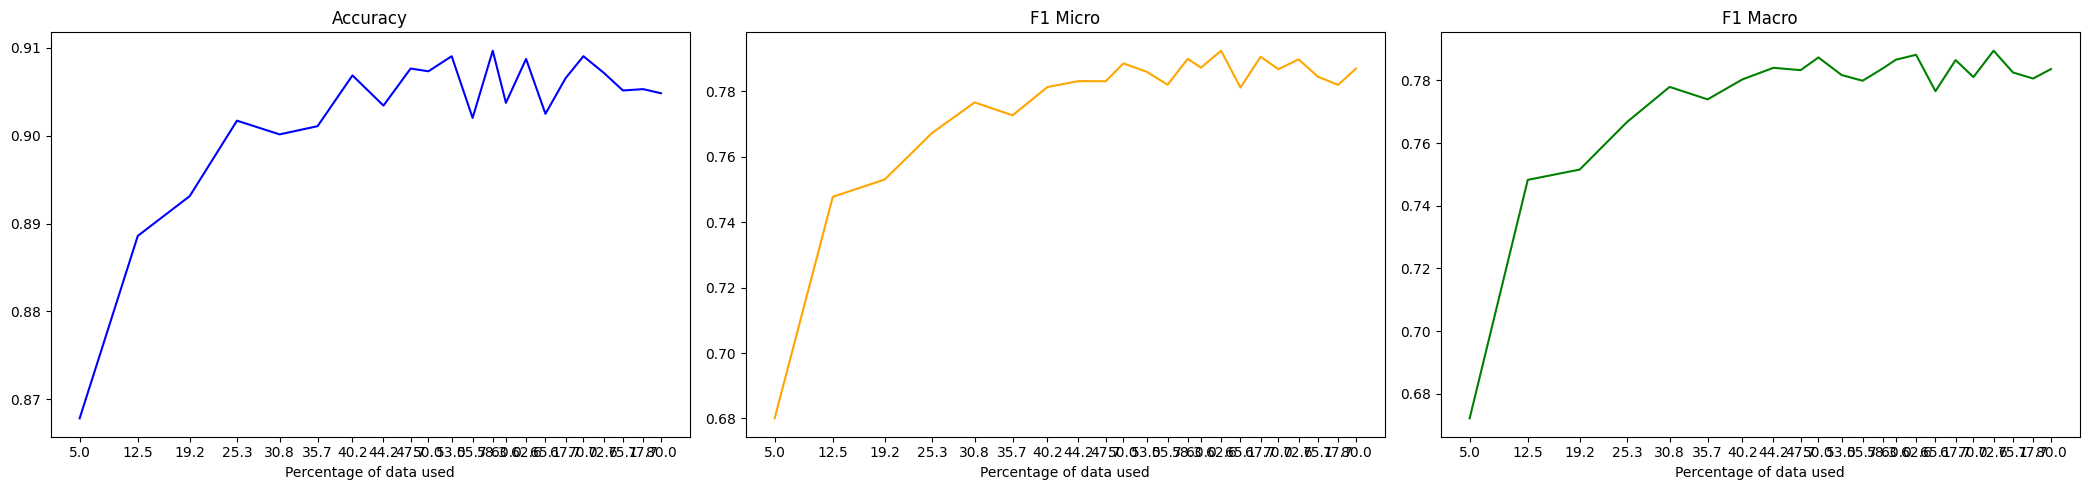

In [19]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5968, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4973, Accuracy: 0.7958, F1 Micro: 0.0815, F1 Macro: 0.0678
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4357, Accuracy: 0.8263, F1 Micro: 0.3178, F1 Macro: 0.2216
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4166, Accuracy: 0.8441, F1 Micro: 0.4791, F1 Macro: 0.4013
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3434, Accuracy: 0.848, F1 Micro: 0.5003, F1 Macro: 0.4164
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3181, Accuracy: 0.8561, F1 Micro: 0.569, F1 Macro: 0.4892
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.28, Accuracy: 0.8608, F1 Micro: 0.6101, F1 Macro: 0.56
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2362, Accuracy: 0.8725, F1 Micro: 0.6686, F1 Macro: 0.6486
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1874, Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6022, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5116, Accuracy: 0.8517, F1 Micro: 0.6103, F1 Macro: 0.5964
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4216, Accuracy: 0.8658, F1 Micro: 0.6579, F1 Macro: 0.6603
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3609, Accuracy: 0.8802, F1 Micro: 0.6931, F1 Macro: 0.6859
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.308, Accuracy: 0.8867, F1 Micro: 0.7025, F1 Macro: 0.6976
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2606, Accuracy: 0.8886, F1 Micro: 0.7403, F1 Macro: 0.7366
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.199, Accuracy: 0.8919, F1 Micro: 0.7412, F1 Macro: 0.7414
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1575, Accuracy: 0.8855, F1 Micro: 0.7482, F1 Macro: 0.7492
Epoch 9/10, Train Loss: 0.1165, Accuracy: 0.8898, F1 Micro: 0.73

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5865, Accuracy: 0.8059, F1 Micro: 0.2554, F1 Macro: 0.215
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.483, Accuracy: 0.8677, F1 Micro: 0.6533, F1 Macro: 0.6387
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3968, Accuracy: 0.8845, F1 Micro: 0.7112, F1 Macro: 0.7046
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3213, Accuracy: 0.8931, F1 Micro: 0.7518, F1 Macro: 0.7501
Epoch 5/10, Train Loss: 0.2659, Accuracy: 0.8956, F1 Micro: 0.7401, F1 Macro: 0.742
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2088, Accuracy: 0.8963, F1 Micro: 0.755, F1 Macro: 0.7479
Epoch 7/10, Train Loss: 0.1699, Accuracy: 0.8936, F1 Micro: 0.7447, F1 Macro: 0.7399
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.13, Accuracy: 0.8977, F1 Micro: 0.7596, F1 Macro: 0.7598
Epoch 9/10, Train Loss: 0.1043, Accuracy: 0.8969, F1 Micro: 0.7462, F1 Macro: 0.7386
Epoch 10/10, Train Loss: 0.0746, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5663, Accuracy: 0.8342, F1 Micro: 0.5703, F1 Macro: 0.4836
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4493, Accuracy: 0.8647, F1 Micro: 0.6028, F1 Macro: 0.5767
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3775, Accuracy: 0.8894, F1 Micro: 0.7455, F1 Macro: 0.732
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3045, Accuracy: 0.8958, F1 Micro: 0.7656, F1 Macro: 0.7633
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2653, Accuracy: 0.9019, F1 Micro: 0.7698, F1 Macro: 0.7676
Epoch 6/10, Train Loss: 0.2016, Accuracy: 0.9005, F1 Micro: 0.765, F1 Macro: 0.7572
Epoch 7/10, Train Loss: 0.1497, Accuracy: 0.9002, F1 Micro: 0.7645, F1 Macro: 0.7585
Epoch 8/10, Train Loss: 0.1131, Accuracy: 0.9005, F1 Micro: 0.7693, F1 Macro: 0.7656
Epoch 9/10, Train Loss: 0.0816, Accuracy: 0.8995, F1 Micro: 0.7635, F1 Macro: 0.755
Epoch 10/10, Train Loss: 0.0659, Accuracy: 0.9014, F1 Micro: 0.7643, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5412, Accuracy: 0.8377, F1 Micro: 0.447, F1 Macro: 0.3726
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4234, Accuracy: 0.8867, F1 Micro: 0.7261, F1 Macro: 0.7057
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3509, Accuracy: 0.8958, F1 Micro: 0.7577, F1 Macro: 0.7536
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2842, Accuracy: 0.9019, F1 Micro: 0.763, F1 Macro: 0.7581
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2296, Accuracy: 0.9011, F1 Micro: 0.7692, F1 Macro: 0.7645
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1862, Accuracy: 0.9041, F1 Micro: 0.781, F1 Macro: 0.7774
Epoch 7/10, Train Loss: 0.1238, Accuracy: 0.8992, F1 Micro: 0.7513, F1 Macro: 0.7438
Epoch 8/10, Train Loss: 0.1025, Accuracy: 0.8995, F1 Micro: 0.7602, F1 Macro: 0.7508
Epoch 9/10, Train Loss: 0.0779, Accuracy: 0.9022, F1 Micro: 0.7687, F1 Macro: 0.7672
Epoch 10/10, Train Loss: 0.0638, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5254, Accuracy: 0.8753, F1 Micro: 0.7062, F1 Macro: 0.6993
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4017, Accuracy: 0.8942, F1 Micro: 0.7427, F1 Macro: 0.7351
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3249, Accuracy: 0.8922, F1 Micro: 0.768, F1 Macro: 0.771
Epoch 4/10, Train Loss: 0.2821, Accuracy: 0.9048, F1 Micro: 0.7644, F1 Macro: 0.7559
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.223, Accuracy: 0.9034, F1 Micro: 0.7754, F1 Macro: 0.7707
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1633, Accuracy: 0.9028, F1 Micro: 0.7764, F1 Macro: 0.773
Epoch 7/10, Train Loss: 0.1254, Accuracy: 0.8995, F1 Micro: 0.7717, F1 Macro: 0.7641
Epoch 8/10, Train Loss: 0.0944, Accuracy: 0.8995, F1 Micro: 0.769, F1 Macro: 0.7651
Epoch 9/10, Train Loss: 0.0662, Accuracy: 0.8994, F1 Micro: 0.7672, F1 Macro: 0.7654
Epoch 10/10, Train Loss: 0.0607, Accuracy: 0.8984, F1 Micro: 0.7679, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5105, Accuracy: 0.8683, F1 Micro: 0.6619, F1 Macro: 0.6598
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3797, Accuracy: 0.8913, F1 Micro: 0.7273, F1 Macro: 0.7255
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3163, Accuracy: 0.9013, F1 Micro: 0.7671, F1 Macro: 0.7611
Epoch 4/10, Train Loss: 0.2559, Accuracy: 0.9008, F1 Micro: 0.759, F1 Macro: 0.7545
Epoch 5/10, Train Loss: 0.21, Accuracy: 0.9013, F1 Micro: 0.7597, F1 Macro: 0.7469
Epoch 6/10, Train Loss: 0.156, Accuracy: 0.9027, F1 Micro: 0.7637, F1 Macro: 0.7552
Epoch 7/10, Train Loss: 0.1112, Accuracy: 0.8989, F1 Micro: 0.761, F1 Macro: 0.7572
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0904, Accuracy: 0.9019, F1 Micro: 0.7693, F1 Macro: 0.7626
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0766, Accuracy: 0.8997, F1 Micro: 0.7696, F1 Macro: 0.7631
Epoch 10/10, Train Loss: 0.0551, Accuracy: 0.9022, F1 Micro: 0.764, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5005, Accuracy: 0.8761, F1 Micro: 0.6872, F1 Macro: 0.6723
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3683, Accuracy: 0.8913, F1 Micro: 0.7451, F1 Macro: 0.7377
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3093, Accuracy: 0.9028, F1 Micro: 0.7677, F1 Macro: 0.7638
Epoch 4/10, Train Loss: 0.251, Accuracy: 0.8991, F1 Micro: 0.7512, F1 Macro: 0.7426
Epoch 5/10, Train Loss: 0.2034, Accuracy: 0.9011, F1 Micro: 0.7542, F1 Macro: 0.7456
Epoch 6/10, Train Loss: 0.1494, Accuracy: 0.9033, F1 Micro: 0.7667, F1 Macro: 0.7614
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1199, Accuracy: 0.9034, F1 Micro: 0.7725, F1 Macro: 0.7682
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0972, Accuracy: 0.9013, F1 Micro: 0.7767, F1 Macro: 0.7702
Epoch 9/10, Train Loss: 0.0747, Accuracy: 0.903, F1 Micro: 0.7666, F1 Macro: 0.7586
Epoch 10/10, Train Loss: 0.0535, Accuracy: 0.9009, F1 Micro: 0.7736, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4859, Accuracy: 0.8816, F1 Micro: 0.7094, F1 Macro: 0.7037
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3603, Accuracy: 0.8991, F1 Micro: 0.756, F1 Macro: 0.7459
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2947, Accuracy: 0.9031, F1 Micro: 0.7721, F1 Macro: 0.7711
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2541, Accuracy: 0.9059, F1 Micro: 0.7825, F1 Macro: 0.7794
Epoch 5/10, Train Loss: 0.191, Accuracy: 0.9036, F1 Micro: 0.7754, F1 Macro: 0.7699
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1547, Accuracy: 0.9002, F1 Micro: 0.7826, F1 Macro: 0.7828
Epoch 7/10, Train Loss: 0.116, Accuracy: 0.9069, F1 Micro: 0.7729, F1 Macro: 0.7617
Epoch 8/10, Train Loss: 0.0878, Accuracy: 0.9017, F1 Micro: 0.7647, F1 Macro: 0.7527
Epoch 9/10, Train Loss: 0.0698, Accuracy: 0.8988, F1 Micro: 0.7823, F1 Macro: 0.7838
Epoch 10/10, Train Loss: 0.0535, Accuracy: 0.9022, F1 Micro: 0.7683, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.482, Accuracy: 0.8827, F1 Micro: 0.7093, F1 Macro: 0.7124
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3526, Accuracy: 0.8973, F1 Micro: 0.7431, F1 Macro: 0.737
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2874, Accuracy: 0.9022, F1 Micro: 0.7641, F1 Macro: 0.7596
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2413, Accuracy: 0.9052, F1 Micro: 0.7819, F1 Macro: 0.777
Epoch 5/10, Train Loss: 0.1859, Accuracy: 0.9047, F1 Micro: 0.7656, F1 Macro: 0.7601
Epoch 6/10, Train Loss: 0.1427, Accuracy: 0.9022, F1 Micro: 0.7714, F1 Macro: 0.7659
Epoch 7/10, Train Loss: 0.1096, Accuracy: 0.8998, F1 Micro: 0.7637, F1 Macro: 0.7586
Epoch 8/10, Train Loss: 0.0807, Accuracy: 0.9005, F1 Micro: 0.7774, F1 Macro: 0.7766
Epoch 9/10, Train Loss: 0.0638, Accuracy: 0.8998, F1 Micro: 0.7707, F1 Macro: 0.7691
Epoch 10/10, Train Loss: 0.0546, Accuracy: 0.8989, F1 Micro: 0.775, F1 Macro: 0.7744

 Iteration 3886: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4754, Accuracy: 0.8836, F1 Micro: 0.7084, F1 Macro: 0.7069
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3347, Accuracy: 0.8998, F1 Micro: 0.763, F1 Macro: 0.7568
Epoch 3/10, Train Loss: 0.2828, Accuracy: 0.8955, F1 Micro: 0.7137, F1 Macro: 0.6967
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2293, Accuracy: 0.9066, F1 Micro: 0.7803, F1 Macro: 0.7758
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1796, Accuracy: 0.9066, F1 Micro: 0.7861, F1 Macro: 0.7834
Epoch 6/10, Train Loss: 0.1323, Accuracy: 0.9045, F1 Micro: 0.7787, F1 Macro: 0.7758
Epoch 7/10, Train Loss: 0.0923, Accuracy: 0.9058, F1 Micro: 0.7769, F1 Macro: 0.7715
Epoch 8/10, Train Loss: 0.0707, Accuracy: 0.9027, F1 Micro: 0.775, F1 Macro: 0.7708
Epoch 9/10, Train Loss: 0.063, Accuracy: 0.9055, F1 Micro: 0.7767, F1 Macro: 0.7683
Epoch 10/10, Train Loss: 0.0458, Accuracy: 0.9047, F1 Micro: 0.7744, F1 Macro: 0.7715

 Iteration 4120: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4565, Accuracy: 0.8844, F1 Micro: 0.7145, F1 Macro: 0.7154
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3145, Accuracy: 0.8977, F1 Micro: 0.7612, F1 Macro: 0.7592
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.272, Accuracy: 0.9042, F1 Micro: 0.7818, F1 Macro: 0.7764
Epoch 4/10, Train Loss: 0.2223, Accuracy: 0.9069, F1 Micro: 0.7788, F1 Macro: 0.7727
Epoch 5/10, Train Loss: 0.1714, Accuracy: 0.9027, F1 Micro: 0.7725, F1 Macro: 0.7713
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1279, Accuracy: 0.907, F1 Micro: 0.785, F1 Macro: 0.7776
Epoch 7/10, Train Loss: 0.1001, Accuracy: 0.902, F1 Micro: 0.7595, F1 Macro: 0.7582
Epoch 8/10, Train Loss: 0.0739, Accuracy: 0.9052, F1 Micro: 0.7841, F1 Macro: 0.7812
Epoch 9/10, Train Loss: 0.0577, Accuracy: 0.9003, F1 Micro: 0.7749, F1 Macro: 0.7714
Epoch 10/10, Train Loss: 0.0494, Accuracy: 0.9038, F1 Micro: 0.7719, F1 Macro: 0.7634

 Iteration 4330: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4536, Accuracy: 0.8875, F1 Micro: 0.7391, F1 Macro: 0.7364
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3103, Accuracy: 0.8986, F1 Micro: 0.7505, F1 Macro: 0.7446
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2531, Accuracy: 0.9055, F1 Micro: 0.7755, F1 Macro: 0.7716
Epoch 4/10, Train Loss: 0.2059, Accuracy: 0.9064, F1 Micro: 0.772, F1 Macro: 0.7641
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1689, Accuracy: 0.905, F1 Micro: 0.7833, F1 Macro: 0.7783
Epoch 6/10, Train Loss: 0.129, Accuracy: 0.9062, F1 Micro: 0.7776, F1 Macro: 0.7743
Epoch 7/10, Train Loss: 0.0876, Accuracy: 0.9083, F1 Micro: 0.7792, F1 Macro: 0.7783
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0679, Accuracy: 0.9092, F1 Micro: 0.7874, F1 Macro: 0.7846
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.059, Accuracy: 0.9072, F1 Micro: 0.792, F1 Macro: 0.7938
Epoch 10/10, Train Loss: 0.0461, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4399, Accuracy: 0.8889, F1 Micro: 0.7195, F1 Macro: 0.7062
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3066, Accuracy: 0.9023, F1 Micro: 0.7684, F1 Macro: 0.7581
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2537, Accuracy: 0.9077, F1 Micro: 0.7745, F1 Macro: 0.769
Epoch 4/10, Train Loss: 0.2129, Accuracy: 0.9044, F1 Micro: 0.7621, F1 Macro: 0.7551
Epoch 5/10, Train Loss: 0.1636, Accuracy: 0.9044, F1 Micro: 0.7728, F1 Macro: 0.7663
Epoch 6/10, Train Loss: 0.12, Accuracy: 0.903, F1 Micro: 0.7672, F1 Macro: 0.7588
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0901, Accuracy: 0.9045, F1 Micro: 0.7763, F1 Macro: 0.7722
Epoch 8/10, Train Loss: 0.0726, Accuracy: 0.903, F1 Micro: 0.7607, F1 Macro: 0.753
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0506, Accuracy: 0.9003, F1 Micro: 0.7802, F1 Macro: 0.7792
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0409, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4298, Accuracy: 0.8861, F1 Micro: 0.7023, F1 Macro: 0.6954
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2942, Accuracy: 0.8958, F1 Micro: 0.7335, F1 Macro: 0.7267
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2435, Accuracy: 0.9048, F1 Micro: 0.7781, F1 Macro: 0.7757
Epoch 4/10, Train Loss: 0.1955, Accuracy: 0.9047, F1 Micro: 0.7764, F1 Macro: 0.7733
Epoch 5/10, Train Loss: 0.1535, Accuracy: 0.9011, F1 Micro: 0.7598, F1 Macro: 0.7502
Epoch 6/10, Train Loss: 0.1152, Accuracy: 0.9058, F1 Micro: 0.7694, F1 Macro: 0.7614
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0918, Accuracy: 0.9047, F1 Micro: 0.7782, F1 Macro: 0.775
Epoch 8/10, Train Loss: 0.0632, Accuracy: 0.9038, F1 Micro: 0.7735, F1 Macro: 0.7707
Epoch 9/10, Train Loss: 0.0494, Accuracy: 0.9025, F1 Micro: 0.7741, F1 Macro: 0.7723
Epoch 10/10, Train Loss: 0.0396, Accuracy: 0.9028, F1 Micro: 0.7743, F1 Macro: 0.7691

 Iteration 4863: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4225, Accuracy: 0.8825, F1 Micro: 0.6943, F1 Macro: 0.6861
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2837, Accuracy: 0.9019, F1 Micro: 0.7598, F1 Macro: 0.7545
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2323, Accuracy: 0.9061, F1 Micro: 0.7823, F1 Macro: 0.7784
Epoch 4/10, Train Loss: 0.1831, Accuracy: 0.9034, F1 Micro: 0.7578, F1 Macro: 0.7529
Epoch 5/10, Train Loss: 0.146, Accuracy: 0.902, F1 Micro: 0.7802, F1 Macro: 0.7753
Epoch 6/10, Train Loss: 0.1079, Accuracy: 0.8975, F1 Micro: 0.7791, F1 Macro: 0.7818
Epoch 7/10, Train Loss: 0.0848, Accuracy: 0.9047, F1 Micro: 0.7801, F1 Macro: 0.7809
Epoch 8/10, Train Loss: 0.0631, Accuracy: 0.9042, F1 Micro: 0.7747, F1 Macro: 0.7715
Epoch 9/10, Train Loss: 0.0449, Accuracy: 0.9064, F1 Micro: 0.7728, F1 Macro: 0.7657
Epoch 10/10, Train Loss: 0.0343, Accuracy: 0.9014, F1 Micro: 0.7736, F1 Macro: 0.7693

 Iteration 5063: Accuracy: 0.9061, F1 Micro: 0.7823

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4156, Accuracy: 0.8863, F1 Micro: 0.718, F1 Macro: 0.712
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2769, Accuracy: 0.8953, F1 Micro: 0.7741, F1 Macro: 0.7739
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2249, Accuracy: 0.8998, F1 Micro: 0.7838, F1 Macro: 0.7856
Epoch 4/10, Train Loss: 0.1863, Accuracy: 0.9042, F1 Micro: 0.7813, F1 Macro: 0.774
Epoch 5/10, Train Loss: 0.144, Accuracy: 0.9064, F1 Micro: 0.773, F1 Macro: 0.765
Epoch 6/10, Train Loss: 0.1021, Accuracy: 0.9052, F1 Micro: 0.7822, F1 Macro: 0.78
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0744, Accuracy: 0.9003, F1 Micro: 0.7846, F1 Macro: 0.7866
Epoch 8/10, Train Loss: 0.0612, Accuracy: 0.9061, F1 Micro: 0.7796, F1 Macro: 0.774
Epoch 9/10, Train Loss: 0.0479, Accuracy: 0.903, F1 Micro: 0.7744, F1 Macro: 0.7692
Epoch 10/10, Train Loss: 0.0398, Accuracy: 0.9028, F1 Micro: 0.7665, F1 Macro: 0.761

 Iteration 5263: Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3991, Accuracy: 0.8902, F1 Micro: 0.7225, F1 Macro: 0.6982
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.269, Accuracy: 0.8991, F1 Micro: 0.7676, F1 Macro: 0.7642
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2234, Accuracy: 0.9006, F1 Micro: 0.7781, F1 Macro: 0.774
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1768, Accuracy: 0.9069, F1 Micro: 0.7796, F1 Macro: 0.7727
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1336, Accuracy: 0.9022, F1 Micro: 0.7805, F1 Macro: 0.7781
Epoch 6/10, Train Loss: 0.1022, Accuracy: 0.9003, F1 Micro: 0.7783, F1 Macro: 0.7793
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0753, Accuracy: 0.9023, F1 Micro: 0.7856, F1 Macro: 0.7851
Epoch 8/10, Train Loss: 0.0544, Accuracy: 0.9028, F1 Micro: 0.7772, F1 Macro: 0.7746
Epoch 9/10, Train Loss: 0.0439, Accuracy: 0.9042, F1 Micro: 0.7789, F1 Macro: 0.7727
Epoch 10/10, Train Loss: 0.0364, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3841, Accuracy: 0.8905, F1 Micro: 0.7383, F1 Macro: 0.7307
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2514, Accuracy: 0.9003, F1 Micro: 0.76, F1 Macro: 0.7439
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2077, Accuracy: 0.905, F1 Micro: 0.7755, F1 Macro: 0.7667
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.179, Accuracy: 0.9014, F1 Micro: 0.7825, F1 Macro: 0.7803
Epoch 5/10, Train Loss: 0.1358, Accuracy: 0.9013, F1 Micro: 0.7795, F1 Macro: 0.777
Epoch 6/10, Train Loss: 0.0988, Accuracy: 0.905, F1 Micro: 0.7738, F1 Macro: 0.768
Epoch 7/10, Train Loss: 0.073, Accuracy: 0.9009, F1 Micro: 0.7774, F1 Macro: 0.7729
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0581, Accuracy: 0.9019, F1 Micro: 0.7855, F1 Macro: 0.7864
Epoch 9/10, Train Loss: 0.0418, Accuracy: 0.9036, F1 Micro: 0.7765, F1 Macro: 0.7721
Epoch 10/10, Train Loss: 0.0341, Accuracy: 0.9052, F1 Micro: 0.7813, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3726, Accuracy: 0.8927, F1 Micro: 0.7424, F1 Macro: 0.737
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2472, Accuracy: 0.9038, F1 Micro: 0.7771, F1 Macro: 0.7683
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1999, Accuracy: 0.9069, F1 Micro: 0.7822, F1 Macro: 0.7778
Epoch 4/10, Train Loss: 0.1633, Accuracy: 0.9087, F1 Micro: 0.7781, F1 Macro: 0.7719
Epoch 5/10, Train Loss: 0.1201, Accuracy: 0.9017, F1 Micro: 0.7754, F1 Macro: 0.7706
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0909, Accuracy: 0.9013, F1 Micro: 0.783, F1 Macro: 0.7798
Epoch 7/10, Train Loss: 0.0711, Accuracy: 0.905, F1 Micro: 0.7787, F1 Macro: 0.7783
Epoch 8/10, Train Loss: 0.0523, Accuracy: 0.9055, F1 Micro: 0.7752, F1 Macro: 0.771
Epoch 9/10, Train Loss: 0.0371, Accuracy: 0.9034, F1 Micro: 0.768, F1 Macro: 0.761
Epoch 10/10, Train Loss: 0.0323, Accuracy: 0.902, F1 Micro: 0.7796, F1 Macro: 0.7783

 Iteration 5841: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3688, Accuracy: 0.8966, F1 Micro: 0.7591, F1 Macro: 0.7519
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2394, Accuracy: 0.9023, F1 Micro: 0.7595, F1 Macro: 0.7505
Epoch 3/10, Train Loss: 0.1995, Accuracy: 0.9041, F1 Micro: 0.7548, F1 Macro: 0.7374
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.155, Accuracy: 0.9041, F1 Micro: 0.7653, F1 Macro: 0.761
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1176, Accuracy: 0.9041, F1 Micro: 0.7887, F1 Macro: 0.7877
Epoch 6/10, Train Loss: 0.0902, Accuracy: 0.9066, F1 Micro: 0.7784, F1 Macro: 0.7757
Epoch 7/10, Train Loss: 0.0672, Accuracy: 0.9103, F1 Micro: 0.7797, F1 Macro: 0.7733
Epoch 8/10, Train Loss: 0.0532, Accuracy: 0.9042, F1 Micro: 0.7778, F1 Macro: 0.7724
Epoch 9/10, Train Loss: 0.0394, Accuracy: 0.9027, F1 Micro: 0.7766, F1 Macro: 0.7655
Epoch 10/10, Train Loss: 0.0323, Accuracy: 0.9053, F1 Micro: 0.7823, F1 Macro: 0.7798

 Iteration 6041: A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3551, Accuracy: 0.8884, F1 Micro: 0.7098, F1 Macro: 0.6977
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2271, Accuracy: 0.8989, F1 Micro: 0.7425, F1 Macro: 0.7398
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1868, Accuracy: 0.9064, F1 Micro: 0.78, F1 Macro: 0.7757
Epoch 4/10, Train Loss: 0.1431, Accuracy: 0.8975, F1 Micro: 0.7331, F1 Macro: 0.7151
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1204, Accuracy: 0.9047, F1 Micro: 0.7825, F1 Macro: 0.7785
Epoch 6/10, Train Loss: 0.0839, Accuracy: 0.9028, F1 Micro: 0.7755, F1 Macro: 0.7741
Epoch 7/10, Train Loss: 0.0586, Accuracy: 0.8975, F1 Micro: 0.7698, F1 Macro: 0.7681
Epoch 8/10, Train Loss: 0.0521, Accuracy: 0.9045, F1 Micro: 0.7814, F1 Macro: 0.7794
Epoch 9/10, Train Loss: 0.0355, Accuracy: 0.905, F1 Micro: 0.7748, F1 Macro: 0.7689
Epoch 10/10, Train Loss: 0.0292, Accuracy: 0.9036, F1 Micro: 0.7734, F1 Macro: 0.7673

 Iteration 6218: Ac

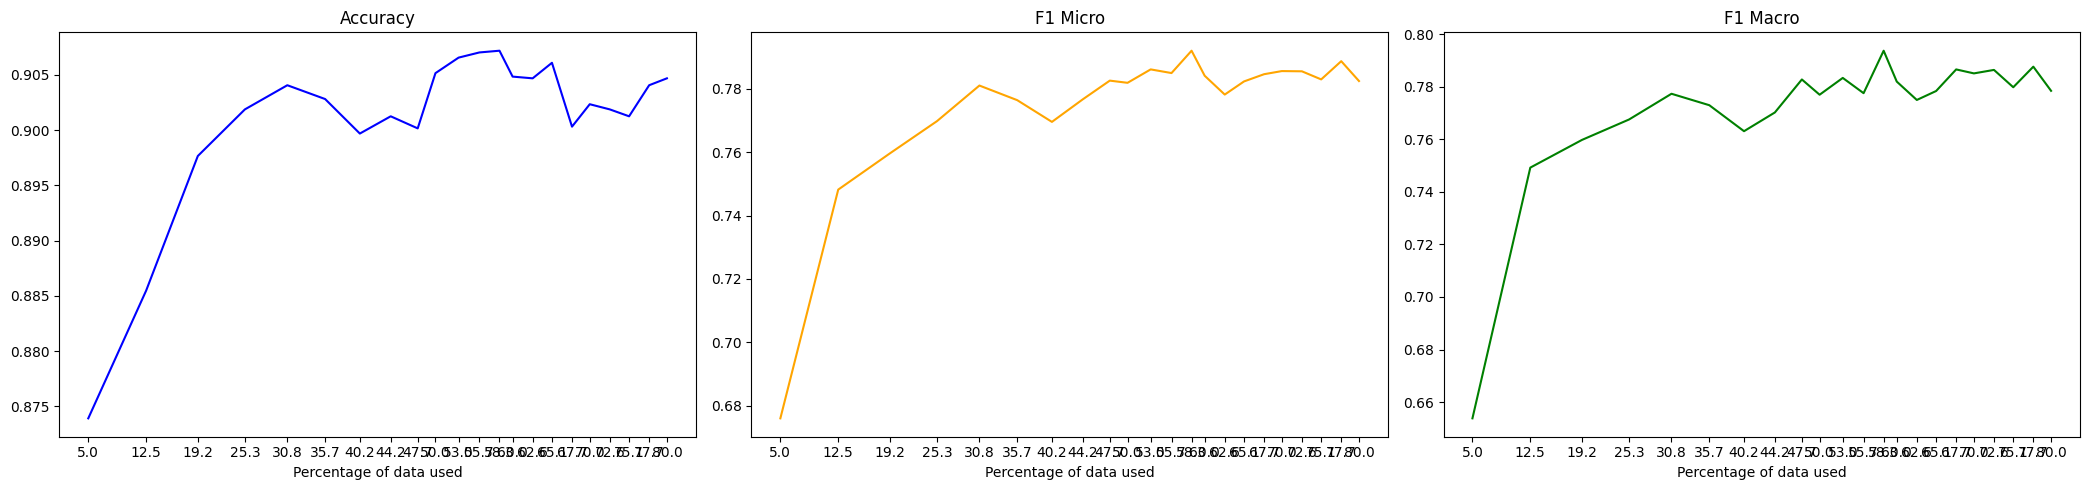

In [20]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.573, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4299, Accuracy: 0.793, F1 Micro: 0.0569, F1 Macro: 0.0488
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.398, Accuracy: 0.8236, F1 Micro: 0.2957, F1 Macro: 0.2101
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3572, Accuracy: 0.8389, F1 Micro: 0.4256, F1 Macro: 0.3377
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2998, Accuracy: 0.8417, F1 Micro: 0.4468, F1 Macro: 0.3645
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2759, Accuracy: 0.8531, F1 Micro: 0.5406, F1 Macro: 0.4609
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2245, Accuracy: 0.8637, F1 Micro: 0.6152, F1 Macro: 0.5822
Epoch 8/10, Train Loss: 0.1944, Accuracy: 0.8647, F1 Micro: 0.5957, F1 Macro: 0.5446
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1747, Accuracy: 0.8687, F1 Micro: 0.643

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5799, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5009, Accuracy: 0.8414, F1 Micro: 0.476, F1 Macro: 0.4186
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.408, Accuracy: 0.8608, F1 Micro: 0.6097, F1 Macro: 0.6057
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3304, Accuracy: 0.8786, F1 Micro: 0.6881, F1 Macro: 0.6857
Epoch 5/10, Train Loss: 0.2894, Accuracy: 0.8806, F1 Micro: 0.6853, F1 Macro: 0.687
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2167, Accuracy: 0.8822, F1 Micro: 0.691, F1 Macro: 0.6902
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.19, Accuracy: 0.8898, F1 Micro: 0.7221, F1 Macro: 0.7135
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1501, Accuracy: 0.8911, F1 Micro: 0.7363, F1 Macro: 0.7293
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1096, Accuracy: 0.8875, F1 Micro: 0.7418, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5622, Accuracy: 0.7878, F1 Micro: 0.0188, F1 Macro: 0.0233
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4725, Accuracy: 0.8617, F1 Micro: 0.595, F1 Macro: 0.5986
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3941, Accuracy: 0.8736, F1 Micro: 0.6311, F1 Macro: 0.6076
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3226, Accuracy: 0.8888, F1 Micro: 0.7094, F1 Macro: 0.6887
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.267, Accuracy: 0.895, F1 Micro: 0.7569, F1 Macro: 0.7564
Epoch 6/10, Train Loss: 0.2099, Accuracy: 0.8973, F1 Micro: 0.7474, F1 Macro: 0.7444
Epoch 7/10, Train Loss: 0.1708, Accuracy: 0.8984, F1 Micro: 0.7545, F1 Macro: 0.7499
Epoch 8/10, Train Loss: 0.1368, Accuracy: 0.8977, F1 Micro: 0.7522, F1 Macro: 0.7434
Epoch 9/10, Train Loss: 0.0992, Accuracy: 0.8967, F1 Micro: 0.7514, F1 Macro: 0.7436
Epoch 10/10, Train Loss: 0.0736, Accuracy: 0.8963, F1 Micro: 0.7483, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5498, Accuracy: 0.8222, F1 Micro: 0.3467, F1 Macro: 0.3068
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4485, Accuracy: 0.8711, F1 Micro: 0.655, F1 Macro: 0.6531
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3791, Accuracy: 0.8855, F1 Micro: 0.7014, F1 Macro: 0.6749
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3067, Accuracy: 0.9, F1 Micro: 0.75, F1 Macro: 0.7401
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2537, Accuracy: 0.9027, F1 Micro: 0.774, F1 Macro: 0.7722
Epoch 6/10, Train Loss: 0.1834, Accuracy: 0.8992, F1 Micro: 0.7585, F1 Macro: 0.7489
Epoch 7/10, Train Loss: 0.1453, Accuracy: 0.9016, F1 Micro: 0.7668, F1 Macro: 0.7652
Epoch 8/10, Train Loss: 0.1227, Accuracy: 0.9003, F1 Micro: 0.7609, F1 Macro: 0.7507
Epoch 9/10, Train Loss: 0.086, Accuracy: 0.9014, F1 Micro: 0.7643, F1 Macro: 0.7611
Epoch 10/10, Train Loss: 0.0673, Accuracy: 0.9013, F1 Micro: 0.7622, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5341, Accuracy: 0.8545, F1 Micro: 0.5915, F1 Macro: 0.5638
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4122, Accuracy: 0.8777, F1 Micro: 0.6859, F1 Macro: 0.6891
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3423, Accuracy: 0.8983, F1 Micro: 0.7565, F1 Macro: 0.7528
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2875, Accuracy: 0.8967, F1 Micro: 0.7693, F1 Macro: 0.7711
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2285, Accuracy: 0.9025, F1 Micro: 0.7723, F1 Macro: 0.7704
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1762, Accuracy: 0.9009, F1 Micro: 0.7745, F1 Macro: 0.771
Epoch 7/10, Train Loss: 0.128, Accuracy: 0.9044, F1 Micro: 0.7687, F1 Macro: 0.7599
Epoch 8/10, Train Loss: 0.1026, Accuracy: 0.902, F1 Micro: 0.7668, F1 Macro: 0.7626
Epoch 9/10, Train Loss: 0.079, Accuracy: 0.9016, F1 Micro: 0.7726, F1 Macro: 0.77
Epoch 10/10, Train Loss: 0.0586, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.521, Accuracy: 0.8603, F1 Micro: 0.6458, F1 Macro: 0.6404
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4022, Accuracy: 0.8878, F1 Micro: 0.7266, F1 Macro: 0.7216
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3376, Accuracy: 0.9016, F1 Micro: 0.7677, F1 Macro: 0.7625
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2817, Accuracy: 0.8933, F1 Micro: 0.7695, F1 Macro: 0.7707
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2362, Accuracy: 0.9038, F1 Micro: 0.773, F1 Macro: 0.7695
Epoch 6/10, Train Loss: 0.1783, Accuracy: 0.9005, F1 Micro: 0.7727, F1 Macro: 0.7715
Epoch 7/10, Train Loss: 0.1229, Accuracy: 0.9028, F1 Micro: 0.771, F1 Macro: 0.7635
Epoch 8/10, Train Loss: 0.102, Accuracy: 0.9013, F1 Micro: 0.7715, F1 Macro: 0.7679
Epoch 9/10, Train Loss: 0.0765, Accuracy: 0.8964, F1 Micro: 0.7684, F1 Macro: 0.7634
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0553, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5174, Accuracy: 0.8494, F1 Micro: 0.5126, F1 Macro: 0.4463
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3791, Accuracy: 0.8919, F1 Micro: 0.7234, F1 Macro: 0.7037
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3189, Accuracy: 0.8995, F1 Micro: 0.7351, F1 Macro: 0.7216
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2723, Accuracy: 0.9025, F1 Micro: 0.7701, F1 Macro: 0.7633
Epoch 5/10, Train Loss: 0.2073, Accuracy: 0.9036, F1 Micro: 0.7543, F1 Macro: 0.7473
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1682, Accuracy: 0.9066, F1 Micro: 0.785, F1 Macro: 0.7827
Epoch 7/10, Train Loss: 0.1278, Accuracy: 0.9044, F1 Micro: 0.7745, F1 Macro: 0.7663
Epoch 8/10, Train Loss: 0.092, Accuracy: 0.9044, F1 Micro: 0.7691, F1 Macro: 0.7606
Epoch 9/10, Train Loss: 0.0734, Accuracy: 0.9058, F1 Micro: 0.7822, F1 Macro: 0.7777
Epoch 10/10, Train Loss: 0.0601, Accuracy: 0.9044, F1 Micro: 0.7794, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5013, Accuracy: 0.8631, F1 Micro: 0.6165, F1 Macro: 0.5736
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3787, Accuracy: 0.8908, F1 Micro: 0.7501, F1 Macro: 0.7373
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3128, Accuracy: 0.9008, F1 Micro: 0.7668, F1 Macro: 0.7599
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2707, Accuracy: 0.9014, F1 Micro: 0.7804, F1 Macro: 0.7829
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2125, Accuracy: 0.9041, F1 Micro: 0.7823, F1 Macro: 0.774
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1647, Accuracy: 0.9013, F1 Micro: 0.783, F1 Macro: 0.7832
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1264, Accuracy: 0.9058, F1 Micro: 0.7852, F1 Macro: 0.7831
Epoch 8/10, Train Loss: 0.0857, Accuracy: 0.9044, F1 Micro: 0.7786, F1 Macro: 0.7752
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0671, Accuracy: 0.9073, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4918, Accuracy: 0.8655, F1 Micro: 0.6725, F1 Macro: 0.6309
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3623, Accuracy: 0.8952, F1 Micro: 0.7321, F1 Macro: 0.7152
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2965, Accuracy: 0.8998, F1 Micro: 0.7702, F1 Macro: 0.7675
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.244, Accuracy: 0.9047, F1 Micro: 0.7727, F1 Macro: 0.7653
Epoch 5/10, Train Loss: 0.1957, Accuracy: 0.9069, F1 Micro: 0.7706, F1 Macro: 0.763
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1454, Accuracy: 0.9045, F1 Micro: 0.7798, F1 Macro: 0.7745
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1144, Accuracy: 0.9078, F1 Micro: 0.784, F1 Macro: 0.7803
Epoch 8/10, Train Loss: 0.0796, Accuracy: 0.9011, F1 Micro: 0.7766, F1 Macro: 0.7724
Epoch 9/10, Train Loss: 0.0648, Accuracy: 0.9027, F1 Micro: 0.7678, F1 Macro: 0.7564
Epoch 10/10, Train Loss: 0.0572, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4805, Accuracy: 0.8711, F1 Micro: 0.7289, F1 Macro: 0.7318
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3463, Accuracy: 0.8973, F1 Micro: 0.7441, F1 Macro: 0.7371
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.292, Accuracy: 0.9039, F1 Micro: 0.7632, F1 Macro: 0.7452
Epoch 4/10, Train Loss: 0.2357, Accuracy: 0.8998, F1 Micro: 0.7564, F1 Macro: 0.75
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.192, Accuracy: 0.9055, F1 Micro: 0.7896, F1 Macro: 0.7887
Epoch 6/10, Train Loss: 0.1508, Accuracy: 0.9053, F1 Micro: 0.7706, F1 Macro: 0.7671
Epoch 7/10, Train Loss: 0.1141, Accuracy: 0.9081, F1 Micro: 0.7806, F1 Macro: 0.7775
Epoch 8/10, Train Loss: 0.0823, Accuracy: 0.9019, F1 Micro: 0.7822, F1 Macro: 0.7807
Epoch 9/10, Train Loss: 0.0668, Accuracy: 0.9048, F1 Micro: 0.7801, F1 Macro: 0.778
Epoch 10/10, Train Loss: 0.0537, Accuracy: 0.9069, F1 Micro: 0.7839, F1 Macro: 0.7786

 Iteration 3886: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4639, Accuracy: 0.8656, F1 Micro: 0.7097, F1 Macro: 0.7148
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3223, Accuracy: 0.8986, F1 Micro: 0.7627, F1 Macro: 0.7606
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2751, Accuracy: 0.9073, F1 Micro: 0.7829, F1 Macro: 0.7745
Epoch 4/10, Train Loss: 0.2228, Accuracy: 0.9072, F1 Micro: 0.7827, F1 Macro: 0.7751
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1734, Accuracy: 0.9027, F1 Micro: 0.7866, F1 Macro: 0.7825
Epoch 6/10, Train Loss: 0.1375, Accuracy: 0.9009, F1 Micro: 0.7829, F1 Macro: 0.7833
Epoch 7/10, Train Loss: 0.0951, Accuracy: 0.9061, F1 Micro: 0.7853, F1 Macro: 0.7812
Epoch 8/10, Train Loss: 0.0781, Accuracy: 0.9016, F1 Micro: 0.7837, F1 Macro: 0.7846
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0621, Accuracy: 0.9061, F1 Micro: 0.7901, F1 Macro: 0.7896
Epoch 10/10, Train Loss: 0.0535, Accuracy: 0.9044, F1 Micro: 0.7802, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4625, Accuracy: 0.8847, F1 Micro: 0.7162, F1 Macro: 0.7112
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3221, Accuracy: 0.9011, F1 Micro: 0.7637, F1 Macro: 0.759
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2673, Accuracy: 0.9053, F1 Micro: 0.7874, F1 Macro: 0.7834
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2162, Accuracy: 0.9075, F1 Micro: 0.7884, F1 Macro: 0.782
Epoch 5/10, Train Loss: 0.1765, Accuracy: 0.903, F1 Micro: 0.7631, F1 Macro: 0.7646
Epoch 6/10, Train Loss: 0.1337, Accuracy: 0.9078, F1 Micro: 0.7839, F1 Macro: 0.7789
Epoch 7/10, Train Loss: 0.1061, Accuracy: 0.9055, F1 Micro: 0.781, F1 Macro: 0.7776
Epoch 8/10, Train Loss: 0.0795, Accuracy: 0.9025, F1 Micro: 0.7817, F1 Macro: 0.7796
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0591, Accuracy: 0.9064, F1 Micro: 0.7886, F1 Macro: 0.786
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0491, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4504, Accuracy: 0.8763, F1 Micro: 0.7203, F1 Macro: 0.7219
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3225, Accuracy: 0.9005, F1 Micro: 0.7624, F1 Macro: 0.7621
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2596, Accuracy: 0.9041, F1 Micro: 0.7807, F1 Macro: 0.776
Epoch 4/10, Train Loss: 0.2227, Accuracy: 0.9084, F1 Micro: 0.7693, F1 Macro: 0.7613
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.171, Accuracy: 0.9044, F1 Micro: 0.7898, F1 Macro: 0.7866
Epoch 6/10, Train Loss: 0.1327, Accuracy: 0.9114, F1 Micro: 0.784, F1 Macro: 0.7754
Epoch 7/10, Train Loss: 0.0947, Accuracy: 0.9044, F1 Micro: 0.7755, F1 Macro: 0.7681
Epoch 8/10, Train Loss: 0.0766, Accuracy: 0.9072, F1 Micro: 0.7752, F1 Macro: 0.7714
Epoch 9/10, Train Loss: 0.0544, Accuracy: 0.9078, F1 Micro: 0.7828, F1 Macro: 0.7789
Epoch 10/10, Train Loss: 0.0439, Accuracy: 0.9055, F1 Micro: 0.786, F1 Macro: 0.7839

 Iteration 4530: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4381, Accuracy: 0.883, F1 Micro: 0.7048, F1 Macro: 0.6795
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3071, Accuracy: 0.8977, F1 Micro: 0.7621, F1 Macro: 0.7609
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2553, Accuracy: 0.9031, F1 Micro: 0.7844, F1 Macro: 0.7791
Epoch 4/10, Train Loss: 0.2047, Accuracy: 0.9073, F1 Micro: 0.7803, F1 Macro: 0.7765
Epoch 5/10, Train Loss: 0.161, Accuracy: 0.9056, F1 Micro: 0.7726, F1 Macro: 0.7633
Epoch 6/10, Train Loss: 0.1238, Accuracy: 0.9045, F1 Micro: 0.7656, F1 Macro: 0.7566
Epoch 7/10, Train Loss: 0.0908, Accuracy: 0.9036, F1 Micro: 0.7773, F1 Macro: 0.7757
Epoch 8/10, Train Loss: 0.0715, Accuracy: 0.905, F1 Micro: 0.7756, F1 Macro: 0.769
Epoch 9/10, Train Loss: 0.0549, Accuracy: 0.9014, F1 Micro: 0.7785, F1 Macro: 0.7741
Epoch 10/10, Train Loss: 0.0473, Accuracy: 0.9044, F1 Micro: 0.7765, F1 Macro: 0.7709

 Iteration 4663: Accuracy: 0.9031, F1 Micro: 0.7844, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4316, Accuracy: 0.8883, F1 Micro: 0.7289, F1 Macro: 0.7196
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2904, Accuracy: 0.8967, F1 Micro: 0.751, F1 Macro: 0.7432
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2466, Accuracy: 0.9048, F1 Micro: 0.7755, F1 Macro: 0.7717
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2076, Accuracy: 0.907, F1 Micro: 0.7804, F1 Macro: 0.7748
Epoch 5/10, Train Loss: 0.1687, Accuracy: 0.905, F1 Micro: 0.7647, F1 Macro: 0.7535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.118, Accuracy: 0.9047, F1 Micro: 0.7858, F1 Macro: 0.784
Epoch 7/10, Train Loss: 0.0909, Accuracy: 0.9052, F1 Micro: 0.7727, F1 Macro: 0.7611
Epoch 8/10, Train Loss: 0.071, Accuracy: 0.9033, F1 Micro: 0.7803, F1 Macro: 0.7787
Epoch 9/10, Train Loss: 0.0543, Accuracy: 0.9048, F1 Micro: 0.7752, F1 Macro: 0.7708
Epoch 10/10, Train Loss: 0.0431, Accuracy: 0.9036, F1 Micro: 0.7825, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4148, Accuracy: 0.8858, F1 Micro: 0.7137, F1 Macro: 0.708
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2835, Accuracy: 0.902, F1 Micro: 0.7722, F1 Macro: 0.7667
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2349, Accuracy: 0.9038, F1 Micro: 0.7814, F1 Macro: 0.7765
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.197, Accuracy: 0.9103, F1 Micro: 0.7871, F1 Macro: 0.7835
Epoch 5/10, Train Loss: 0.1535, Accuracy: 0.9045, F1 Micro: 0.7822, F1 Macro: 0.7832
Epoch 6/10, Train Loss: 0.1109, Accuracy: 0.9042, F1 Micro: 0.7841, F1 Macro: 0.7821
Epoch 7/10, Train Loss: 0.083, Accuracy: 0.9055, F1 Micro: 0.775, F1 Macro: 0.7698
Epoch 8/10, Train Loss: 0.0584, Accuracy: 0.9019, F1 Micro: 0.7773, F1 Macro: 0.7759
Epoch 9/10, Train Loss: 0.0464, Accuracy: 0.9023, F1 Micro: 0.7711, F1 Macro: 0.7649
Epoch 10/10, Train Loss: 0.0383, Accuracy: 0.9056, F1 Micro: 0.7788, F1 Macro: 0.7746

 Iteration 5063: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4042, Accuracy: 0.8895, F1 Micro: 0.7278, F1 Macro: 0.7183
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2726, Accuracy: 0.8967, F1 Micro: 0.7768, F1 Macro: 0.7751
Epoch 3/10, Train Loss: 0.2311, Accuracy: 0.9045, F1 Micro: 0.7681, F1 Macro: 0.7618
Epoch 4/10, Train Loss: 0.1905, Accuracy: 0.9036, F1 Micro: 0.7515, F1 Macro: 0.7323
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1409, Accuracy: 0.9069, F1 Micro: 0.7779, F1 Macro: 0.774
Epoch 6/10, Train Loss: 0.1129, Accuracy: 0.9019, F1 Micro: 0.7733, F1 Macro: 0.7686
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0787, Accuracy: 0.9047, F1 Micro: 0.7801, F1 Macro: 0.7765
Epoch 8/10, Train Loss: 0.0602, Accuracy: 0.9059, F1 Micro: 0.7744, F1 Macro: 0.768
Epoch 9/10, Train Loss: 0.0465, Accuracy: 0.9038, F1 Micro: 0.7681, F1 Macro: 0.763
Epoch 10/10, Train Loss: 0.0347, Accuracy: 0.9033, F1 Micro: 0.7698, F1 Macro: 0.763

 Iteration 5263: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3925, Accuracy: 0.8892, F1 Micro: 0.7415, F1 Macro: 0.7367
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2631, Accuracy: 0.9009, F1 Micro: 0.7643, F1 Macro: 0.7629
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.215, Accuracy: 0.9062, F1 Micro: 0.7835, F1 Macro: 0.7796
Epoch 4/10, Train Loss: 0.177, Accuracy: 0.9072, F1 Micro: 0.7769, F1 Macro: 0.7733
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1386, Accuracy: 0.9053, F1 Micro: 0.784, F1 Macro: 0.7795
Epoch 6/10, Train Loss: 0.0997, Accuracy: 0.9028, F1 Micro: 0.7761, F1 Macro: 0.7712
Epoch 7/10, Train Loss: 0.075, Accuracy: 0.9036, F1 Micro: 0.7792, F1 Macro: 0.7761
Epoch 8/10, Train Loss: 0.0545, Accuracy: 0.9028, F1 Micro: 0.7828, F1 Macro: 0.782
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0464, Accuracy: 0.9052, F1 Micro: 0.7878, F1 Macro: 0.7855
Epoch 10/10, Train Loss: 0.0351, Accuracy: 0.9064, F1 Micro: 0.7826, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3842, Accuracy: 0.8842, F1 Micro: 0.7509, F1 Macro: 0.7535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2488, Accuracy: 0.8991, F1 Micro: 0.7795, F1 Macro: 0.7749
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.21, Accuracy: 0.8983, F1 Micro: 0.7795, F1 Macro: 0.7804
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1772, Accuracy: 0.9087, F1 Micro: 0.7872, F1 Macro: 0.7831
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1333, Accuracy: 0.9066, F1 Micro: 0.7906, F1 Macro: 0.7909
Epoch 6/10, Train Loss: 0.0979, Accuracy: 0.9072, F1 Micro: 0.7823, F1 Macro: 0.7762
Epoch 7/10, Train Loss: 0.0719, Accuracy: 0.9045, F1 Micro: 0.7756, F1 Macro: 0.7736
Epoch 8/10, Train Loss: 0.0508, Accuracy: 0.902, F1 Micro: 0.7805, F1 Macro: 0.7783
Epoch 9/10, Train Loss: 0.0453, Accuracy: 0.9036, F1 Micro: 0.7759, F1 Macro: 0.7724
Epoch 10/10, Train Loss: 0.0297, Accuracy: 0.9048, F1 Micro: 0.7763, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3716, Accuracy: 0.8902, F1 Micro: 0.7587, F1 Macro: 0.7558
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2515, Accuracy: 0.9003, F1 Micro: 0.7616, F1 Macro: 0.7548
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2022, Accuracy: 0.902, F1 Micro: 0.7815, F1 Macro: 0.7764
Epoch 4/10, Train Loss: 0.1623, Accuracy: 0.9073, F1 Micro: 0.778, F1 Macro: 0.7686
Epoch 5/10, Train Loss: 0.1261, Accuracy: 0.9017, F1 Micro: 0.7661, F1 Macro: 0.7649
Epoch 6/10, Train Loss: 0.095, Accuracy: 0.9025, F1 Micro: 0.7781, F1 Macro: 0.7768
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0679, Accuracy: 0.9016, F1 Micro: 0.7819, F1 Macro: 0.7809
Epoch 8/10, Train Loss: 0.0536, Accuracy: 0.9039, F1 Micro: 0.7807, F1 Macro: 0.7788
Epoch 9/10, Train Loss: 0.0384, Accuracy: 0.903, F1 Micro: 0.7643, F1 Macro: 0.7533
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.032, Accuracy: 0.9034, F1 Micro: 0.7832, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3655, Accuracy: 0.8917, F1 Micro: 0.7542, F1 Macro: 0.7474
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2401, Accuracy: 0.9006, F1 Micro: 0.7682, F1 Macro: 0.7649
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1992, Accuracy: 0.9064, F1 Micro: 0.7816, F1 Macro: 0.7744
Epoch 4/10, Train Loss: 0.1602, Accuracy: 0.9003, F1 Micro: 0.7809, F1 Macro: 0.7759
Epoch 5/10, Train Loss: 0.1199, Accuracy: 0.8975, F1 Micro: 0.7758, F1 Macro: 0.7703
Epoch 6/10, Train Loss: 0.0869, Accuracy: 0.8973, F1 Micro: 0.7679, F1 Macro: 0.7675
Epoch 7/10, Train Loss: 0.0669, Accuracy: 0.9033, F1 Micro: 0.7766, F1 Macro: 0.7724
Epoch 8/10, Train Loss: 0.0503, Accuracy: 0.9047, F1 Micro: 0.7691, F1 Macro: 0.7617
Epoch 9/10, Train Loss: 0.0394, Accuracy: 0.9006, F1 Micro: 0.7765, F1 Macro: 0.7745
Epoch 10/10, Train Loss: 0.0329, Accuracy: 0.9058, F1 Micro: 0.7774, F1 Macro: 0.7715

 Iteration 6041: Accuracy: 0.9064, F1 Micro: 0.78

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3562, Accuracy: 0.8898, F1 Micro: 0.7459, F1 Macro: 0.7361
Epoch 2/10, Train Loss: 0.2345, Accuracy: 0.8995, F1 Micro: 0.7383, F1 Macro: 0.7192
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1914, Accuracy: 0.9061, F1 Micro: 0.7857, F1 Macro: 0.7824
Epoch 4/10, Train Loss: 0.1558, Accuracy: 0.9044, F1 Micro: 0.7847, F1 Macro: 0.7755
Epoch 5/10, Train Loss: 0.1153, Accuracy: 0.9025, F1 Micro: 0.758, F1 Macro: 0.7501
Epoch 6/10, Train Loss: 0.0879, Accuracy: 0.9041, F1 Micro: 0.7813, F1 Macro: 0.7771
Epoch 7/10, Train Loss: 0.0626, Accuracy: 0.9048, F1 Micro: 0.7759, F1 Macro: 0.7678
Epoch 8/10, Train Loss: 0.0433, Accuracy: 0.9022, F1 Micro: 0.7695, F1 Macro: 0.7582
Epoch 9/10, Train Loss: 0.0364, Accuracy: 0.9048, F1 Micro: 0.7735, F1 Macro: 0.7648
Epoch 10/10, Train Loss: 0.0308, Accuracy: 0.9069, F1 Micro: 0.7831, F1 Macro: 0.7789

 Iteration 6218: Accuracy: 0.9061, F1 Micro: 0.7857, F1 Macro: 0.7824
             

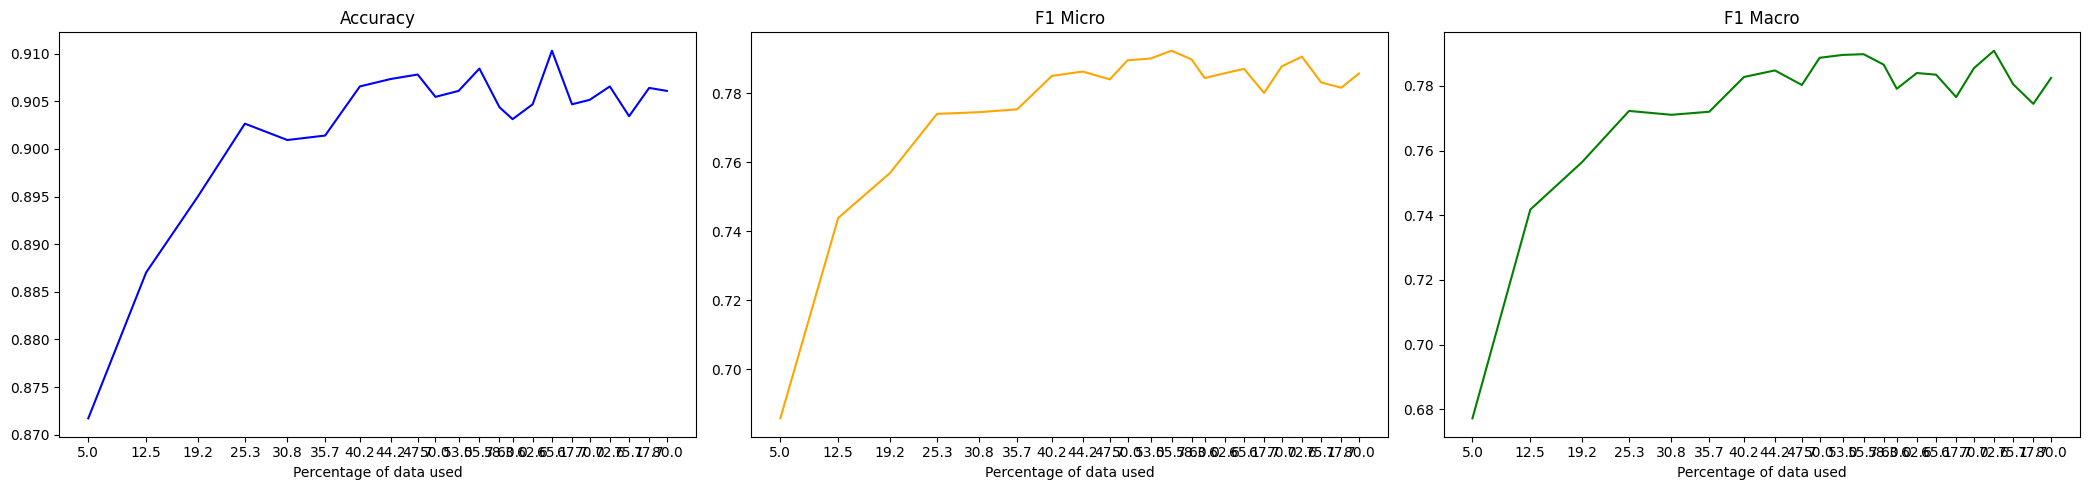

In [21]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6187, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4493, Accuracy: 0.7884, F1 Micro: 0.016, F1 Macro: 0.0144
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4203, Accuracy: 0.8111, F1 Micro: 0.2051, F1 Macro: 0.1483
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3885, Accuracy: 0.8291, F1 Micro: 0.3587, F1 Macro: 0.2765
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3558, Accuracy: 0.8389, F1 Micro: 0.4418, F1 Macro: 0.3567
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2968, Accuracy: 0.855, F1 Micro: 0.5455, F1 Macro: 0.48
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2508, Accuracy: 0.8719, F1 Micro: 0.6664, F1 Macro: 0.6505
Epoch 8/10, Train Loss: 0.2154, Accuracy: 0.8605, F1 Micro: 0.5802, F1 Macro: 0.5478
Epoch 9/10, Train Loss: 0.1636, Accuracy: 0.867, F1 Micro: 0.6343, F1 Macro: 0.6221
Higher F1 achie

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5934, Accuracy: 0.7869, F1 Micro: 0.0029, F1 Macro: 0.003
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4959, Accuracy: 0.8533, F1 Micro: 0.5606, F1 Macro: 0.5348
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4044, Accuracy: 0.8597, F1 Micro: 0.6188, F1 Macro: 0.6139
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3443, Accuracy: 0.8703, F1 Micro: 0.6598, F1 Macro: 0.6688
Epoch 5/10, Train Loss: 0.295, Accuracy: 0.8761, F1 Micro: 0.6551, F1 Macro: 0.6516
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2403, Accuracy: 0.8913, F1 Micro: 0.7422, F1 Macro: 0.7408
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1865, Accuracy: 0.8858, F1 Micro: 0.7463, F1 Macro: 0.7452
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1608, Accuracy: 0.8944, F1 Micro: 0.7489, F1 Macro: 0.7494
Epoch 9/10, Train Loss: 0.1171, Accuracy: 0.892, F1 Micro: 0.7327, F1 Macro: 0.7312
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5845, Accuracy: 0.7972, F1 Micro: 0.1538, F1 Macro: 0.1472
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4661, Accuracy: 0.8616, F1 Micro: 0.6246, F1 Macro: 0.6322
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3745, Accuracy: 0.8795, F1 Micro: 0.6956, F1 Macro: 0.7015
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3266, Accuracy: 0.892, F1 Micro: 0.7274, F1 Macro: 0.7164
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2582, Accuracy: 0.8967, F1 Micro: 0.7478, F1 Macro: 0.7386
Epoch 6/10, Train Loss: 0.1998, Accuracy: 0.8941, F1 Micro: 0.7273, F1 Macro: 0.7121
Epoch 7/10, Train Loss: 0.1626, Accuracy: 0.8978, F1 Micro: 0.7471, F1 Macro: 0.738
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.119, Accuracy: 0.8967, F1 Micro: 0.7549, F1 Macro: 0.7491
Epoch 9/10, Train Loss: 0.0927, Accuracy: 0.8958, F1 Micro: 0.7543, F1 Macro: 0.7466
Epoch 10/10, Train Loss: 0.0759, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5658, Accuracy: 0.85, F1 Micro: 0.601, F1 Macro: 0.5176
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4429, Accuracy: 0.8734, F1 Micro: 0.6702, F1 Macro: 0.6639
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3745, Accuracy: 0.8933, F1 Micro: 0.7549, F1 Macro: 0.7516
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2973, Accuracy: 0.9034, F1 Micro: 0.7735, F1 Macro: 0.7684
Epoch 5/10, Train Loss: 0.2516, Accuracy: 0.9006, F1 Micro: 0.7605, F1 Macro: 0.7555
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1849, Accuracy: 0.9061, F1 Micro: 0.7773, F1 Macro: 0.773
Epoch 7/10, Train Loss: 0.1512, Accuracy: 0.8975, F1 Micro: 0.726, F1 Macro: 0.7139
Epoch 8/10, Train Loss: 0.1167, Accuracy: 0.8988, F1 Micro: 0.7418, F1 Macro: 0.7331
Epoch 9/10, Train Loss: 0.0877, Accuracy: 0.9025, F1 Micro: 0.7618, F1 Macro: 0.7561
Epoch 10/10, Train Loss: 0.0719, Accuracy: 0.9022, F1 Micro: 0.7661, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5494, Accuracy: 0.8628, F1 Micro: 0.627, F1 Macro: 0.6005
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4229, Accuracy: 0.8816, F1 Micro: 0.7366, F1 Macro: 0.739
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3618, Accuracy: 0.8955, F1 Micro: 0.7665, F1 Macro: 0.7644
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2911, Accuracy: 0.9033, F1 Micro: 0.7743, F1 Macro: 0.7682
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.229, Accuracy: 0.9053, F1 Micro: 0.7764, F1 Macro: 0.7699
Epoch 6/10, Train Loss: 0.1871, Accuracy: 0.9036, F1 Micro: 0.7683, F1 Macro: 0.7633
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1477, Accuracy: 0.9033, F1 Micro: 0.7766, F1 Macro: 0.7727
Epoch 8/10, Train Loss: 0.1024, Accuracy: 0.9039, F1 Micro: 0.7626, F1 Macro: 0.7514
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0868, Accuracy: 0.9027, F1 Micro: 0.7782, F1 Macro: 0.7747
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5224, Accuracy: 0.8591, F1 Micro: 0.5816, F1 Macro: 0.553
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3965, Accuracy: 0.8898, F1 Micro: 0.7126, F1 Macro: 0.6812
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3429, Accuracy: 0.8984, F1 Micro: 0.7698, F1 Macro: 0.7639
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2692, Accuracy: 0.9038, F1 Micro: 0.7715, F1 Macro: 0.7703
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2254, Accuracy: 0.9072, F1 Micro: 0.7755, F1 Macro: 0.7663
Epoch 6/10, Train Loss: 0.1689, Accuracy: 0.9009, F1 Micro: 0.7506, F1 Macro: 0.7391
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1275, Accuracy: 0.9048, F1 Micro: 0.7816, F1 Macro: 0.78
Epoch 8/10, Train Loss: 0.0947, Accuracy: 0.9025, F1 Micro: 0.7736, F1 Macro: 0.7703
Epoch 9/10, Train Loss: 0.0742, Accuracy: 0.9055, F1 Micro: 0.7753, F1 Macro: 0.769
Epoch 10/10, Train Loss: 0.0546, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5162, Accuracy: 0.8569, F1 Micro: 0.5562, F1 Macro: 0.5124
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3923, Accuracy: 0.8938, F1 Micro: 0.7395, F1 Macro: 0.7389
Epoch 3/10, Train Loss: 0.3214, Accuracy: 0.8961, F1 Micro: 0.7269, F1 Macro: 0.7172
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2722, Accuracy: 0.8998, F1 Micro: 0.7698, F1 Macro: 0.7701
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2155, Accuracy: 0.9025, F1 Micro: 0.7835, F1 Macro: 0.782
Epoch 6/10, Train Loss: 0.1655, Accuracy: 0.9027, F1 Micro: 0.7734, F1 Macro: 0.771
Epoch 7/10, Train Loss: 0.1277, Accuracy: 0.902, F1 Micro: 0.7713, F1 Macro: 0.7692
Epoch 8/10, Train Loss: 0.0979, Accuracy: 0.9006, F1 Micro: 0.7743, F1 Macro: 0.7738
Epoch 9/10, Train Loss: 0.0758, Accuracy: 0.9019, F1 Micro: 0.7634, F1 Macro: 0.7595
Epoch 10/10, Train Loss: 0.0554, Accuracy: 0.9025, F1 Micro: 0.764, F1 Macro: 0.7597

 Iteration 3122: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5017, Accuracy: 0.877, F1 Micro: 0.7078, F1 Macro: 0.6933
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3674, Accuracy: 0.8945, F1 Micro: 0.7452, F1 Macro: 0.7382
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.301, Accuracy: 0.9006, F1 Micro: 0.7546, F1 Macro: 0.7516
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.257, Accuracy: 0.9019, F1 Micro: 0.7782, F1 Macro: 0.7765
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.201, Accuracy: 0.9033, F1 Micro: 0.7813, F1 Macro: 0.7806
Epoch 6/10, Train Loss: 0.1512, Accuracy: 0.9055, F1 Micro: 0.7721, F1 Macro: 0.7655
Epoch 7/10, Train Loss: 0.1175, Accuracy: 0.9041, F1 Micro: 0.7777, F1 Macro: 0.7753
Epoch 8/10, Train Loss: 0.0895, Accuracy: 0.9041, F1 Micro: 0.7711, F1 Macro: 0.7663
Epoch 9/10, Train Loss: 0.0713, Accuracy: 0.9003, F1 Micro: 0.7775, F1 Macro: 0.7773
Epoch 10/10, Train Loss: 0.0563, Accuracy: 0.9006, F1 Micro: 0.7749, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5011, Accuracy: 0.8827, F1 Micro: 0.7264, F1 Macro: 0.7188
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3632, Accuracy: 0.8934, F1 Micro: 0.765, F1 Macro: 0.7583
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2914, Accuracy: 0.9027, F1 Micro: 0.774, F1 Macro: 0.7714
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2554, Accuracy: 0.9023, F1 Micro: 0.7834, F1 Macro: 0.7836
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2022, Accuracy: 0.9072, F1 Micro: 0.7856, F1 Macro: 0.7824
Epoch 6/10, Train Loss: 0.1538, Accuracy: 0.9047, F1 Micro: 0.7752, F1 Macro: 0.7686
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1208, Accuracy: 0.9083, F1 Micro: 0.7871, F1 Macro: 0.7867
Epoch 8/10, Train Loss: 0.0807, Accuracy: 0.9066, F1 Micro: 0.7861, F1 Macro: 0.7858
Epoch 9/10, Train Loss: 0.0652, Accuracy: 0.9072, F1 Micro: 0.7829, F1 Macro: 0.7794
Epoch 10/10, Train Loss: 0.0487, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4884, Accuracy: 0.867, F1 Micro: 0.6209, F1 Macro: 0.5897
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3528, Accuracy: 0.8975, F1 Micro: 0.7654, F1 Macro: 0.7611
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2895, Accuracy: 0.903, F1 Micro: 0.7783, F1 Macro: 0.7739
Epoch 4/10, Train Loss: 0.2384, Accuracy: 0.8981, F1 Micro: 0.7767, F1 Macro: 0.7779
Epoch 5/10, Train Loss: 0.1989, Accuracy: 0.9036, F1 Micro: 0.7775, F1 Macro: 0.7717
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1492, Accuracy: 0.9075, F1 Micro: 0.7858, F1 Macro: 0.7833
Epoch 7/10, Train Loss: 0.1152, Accuracy: 0.9058, F1 Micro: 0.7825, F1 Macro: 0.7821
Epoch 8/10, Train Loss: 0.0832, Accuracy: 0.9033, F1 Micro: 0.7758, F1 Macro: 0.7705
Epoch 9/10, Train Loss: 0.0639, Accuracy: 0.9033, F1 Micro: 0.783, F1 Macro: 0.7827
Epoch 10/10, Train Loss: 0.052, Accuracy: 0.9064, F1 Micro: 0.773, F1 Macro: 0.7707

 Iteration 3886: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.47, Accuracy: 0.8748, F1 Micro: 0.6863, F1 Macro: 0.6619
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3306, Accuracy: 0.8948, F1 Micro: 0.7552, F1 Macro: 0.7494
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2722, Accuracy: 0.9019, F1 Micro: 0.7705, F1 Macro: 0.7651
Epoch 4/10, Train Loss: 0.2339, Accuracy: 0.9055, F1 Micro: 0.7647, F1 Macro: 0.7573
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1775, Accuracy: 0.9027, F1 Micro: 0.7715, F1 Macro: 0.7717
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1425, Accuracy: 0.9042, F1 Micro: 0.7859, F1 Macro: 0.7879
Epoch 7/10, Train Loss: 0.1089, Accuracy: 0.9064, F1 Micro: 0.7764, F1 Macro: 0.7723
Epoch 8/10, Train Loss: 0.0768, Accuracy: 0.9067, F1 Micro: 0.7833, F1 Macro: 0.7836
Epoch 9/10, Train Loss: 0.0643, Accuracy: 0.9041, F1 Micro: 0.7716, F1 Macro: 0.7637
Epoch 10/10, Train Loss: 0.0473, Accuracy: 0.9022, F1 Micro: 0.7683, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4615, Accuracy: 0.8803, F1 Micro: 0.6792, F1 Macro: 0.682
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3291, Accuracy: 0.8998, F1 Micro: 0.7695, F1 Macro: 0.7663
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2637, Accuracy: 0.9045, F1 Micro: 0.7826, F1 Macro: 0.7796
Epoch 4/10, Train Loss: 0.2201, Accuracy: 0.9066, F1 Micro: 0.7819, F1 Macro: 0.7771
Epoch 5/10, Train Loss: 0.1734, Accuracy: 0.9033, F1 Micro: 0.782, F1 Macro: 0.7799
Epoch 6/10, Train Loss: 0.1377, Accuracy: 0.902, F1 Micro: 0.7804, F1 Macro: 0.7817
Epoch 7/10, Train Loss: 0.1023, Accuracy: 0.9019, F1 Micro: 0.7776, F1 Macro: 0.7769
Epoch 8/10, Train Loss: 0.0766, Accuracy: 0.908, F1 Micro: 0.7795, F1 Macro: 0.7762
Epoch 9/10, Train Loss: 0.0571, Accuracy: 0.8977, F1 Micro: 0.7723, F1 Macro: 0.7732
Epoch 10/10, Train Loss: 0.0496, Accuracy: 0.9044, F1 Micro: 0.7659, F1 Macro: 0.7619

 Iteration 4330: Accuracy: 0.9045, F1 Micro: 0.7826, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4523, Accuracy: 0.8853, F1 Micro: 0.7103, F1 Macro: 0.7082
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3156, Accuracy: 0.8952, F1 Micro: 0.7398, F1 Macro: 0.7318
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2712, Accuracy: 0.9055, F1 Micro: 0.769, F1 Macro: 0.7655
Epoch 4/10, Train Loss: 0.2232, Accuracy: 0.9056, F1 Micro: 0.7677, F1 Macro: 0.758
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1787, Accuracy: 0.9066, F1 Micro: 0.7755, F1 Macro: 0.7745
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1288, Accuracy: 0.9058, F1 Micro: 0.7797, F1 Macro: 0.7755
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0965, Accuracy: 0.905, F1 Micro: 0.783, F1 Macro: 0.7811
Epoch 8/10, Train Loss: 0.0743, Accuracy: 0.9003, F1 Micro: 0.7777, F1 Macro: 0.777
Epoch 9/10, Train Loss: 0.0615, Accuracy: 0.905, F1 Micro: 0.7686, F1 Macro: 0.7624
Epoch 10/10, Train Loss: 0.0463, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4445, Accuracy: 0.8853, F1 Micro: 0.7307, F1 Macro: 0.7323
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3094, Accuracy: 0.8977, F1 Micro: 0.7562, F1 Macro: 0.7446
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2554, Accuracy: 0.9067, F1 Micro: 0.7796, F1 Macro: 0.7753
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2143, Accuracy: 0.9062, F1 Micro: 0.7857, F1 Macro: 0.7829
Epoch 5/10, Train Loss: 0.1707, Accuracy: 0.902, F1 Micro: 0.7795, F1 Macro: 0.7795
Epoch 6/10, Train Loss: 0.1229, Accuracy: 0.9042, F1 Micro: 0.7788, F1 Macro: 0.7738
Epoch 7/10, Train Loss: 0.0975, Accuracy: 0.9089, F1 Micro: 0.7762, F1 Macro: 0.7678
Epoch 8/10, Train Loss: 0.0727, Accuracy: 0.9062, F1 Micro: 0.7799, F1 Macro: 0.7767
Epoch 9/10, Train Loss: 0.0558, Accuracy: 0.8961, F1 Micro: 0.7689, F1 Macro: 0.7657
Epoch 10/10, Train Loss: 0.0427, Accuracy: 0.9042, F1 Micro: 0.7836, F1 Macro: 0.7811

 Iteration 4663: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4289, Accuracy: 0.8806, F1 Micro: 0.6971, F1 Macro: 0.6949
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.299, Accuracy: 0.8969, F1 Micro: 0.7385, F1 Macro: 0.7245
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2414, Accuracy: 0.9045, F1 Micro: 0.782, F1 Macro: 0.7819
Epoch 4/10, Train Loss: 0.2041, Accuracy: 0.9053, F1 Micro: 0.7792, F1 Macro: 0.7767
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1585, Accuracy: 0.9062, F1 Micro: 0.7842, F1 Macro: 0.778
Epoch 6/10, Train Loss: 0.1225, Accuracy: 0.9003, F1 Micro: 0.757, F1 Macro: 0.7437
Epoch 7/10, Train Loss: 0.0876, Accuracy: 0.902, F1 Micro: 0.7696, F1 Macro: 0.7658
Epoch 8/10, Train Loss: 0.0649, Accuracy: 0.9025, F1 Micro: 0.7744, F1 Macro: 0.7685
Epoch 9/10, Train Loss: 0.0567, Accuracy: 0.9002, F1 Micro: 0.7802, F1 Macro: 0.7799
Epoch 10/10, Train Loss: 0.0427, Accuracy: 0.9023, F1 Micro: 0.7795, F1 Macro: 0.7794

 Iteration 4863: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4203, Accuracy: 0.8877, F1 Micro: 0.7253, F1 Macro: 0.724
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2884, Accuracy: 0.9011, F1 Micro: 0.7607, F1 Macro: 0.7483
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2414, Accuracy: 0.908, F1 Micro: 0.7793, F1 Macro: 0.7743
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1972, Accuracy: 0.9058, F1 Micro: 0.7822, F1 Macro: 0.775
Epoch 5/10, Train Loss: 0.1583, Accuracy: 0.9027, F1 Micro: 0.7575, F1 Macro: 0.7471
Epoch 6/10, Train Loss: 0.118, Accuracy: 0.9047, F1 Micro: 0.7645, F1 Macro: 0.7519
Epoch 7/10, Train Loss: 0.0843, Accuracy: 0.9009, F1 Micro: 0.775, F1 Macro: 0.7757
Epoch 8/10, Train Loss: 0.0626, Accuracy: 0.902, F1 Micro: 0.7782, F1 Macro: 0.7766
Epoch 9/10, Train Loss: 0.0509, Accuracy: 0.9033, F1 Micro: 0.7807, F1 Macro: 0.7766
Epoch 10/10, Train Loss: 0.0391, Accuracy: 0.8961, F1 Micro: 0.774, F1 Macro: 0.7758

 Iteration 5063: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4093, Accuracy: 0.8898, F1 Micro: 0.7422, F1 Macro: 0.739
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2869, Accuracy: 0.9027, F1 Micro: 0.7619, F1 Macro: 0.7565
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2303, Accuracy: 0.9005, F1 Micro: 0.7804, F1 Macro: 0.779
Epoch 4/10, Train Loss: 0.1952, Accuracy: 0.902, F1 Micro: 0.7656, F1 Macro: 0.7632
Epoch 5/10, Train Loss: 0.151, Accuracy: 0.9048, F1 Micro: 0.7737, F1 Macro: 0.7608
Epoch 6/10, Train Loss: 0.1126, Accuracy: 0.898, F1 Micro: 0.7755, F1 Macro: 0.7764
Epoch 7/10, Train Loss: 0.0802, Accuracy: 0.9023, F1 Micro: 0.77, F1 Macro: 0.7679
Epoch 8/10, Train Loss: 0.0595, Accuracy: 0.9034, F1 Micro: 0.7733, F1 Macro: 0.7698
Epoch 9/10, Train Loss: 0.0515, Accuracy: 0.8995, F1 Micro: 0.7734, F1 Macro: 0.7695
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0372, Accuracy: 0.9028, F1 Micro: 0.7805, F1 Macro: 0.7802

 Iteration 5263: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4013, Accuracy: 0.8875, F1 Micro: 0.7101, F1 Macro: 0.7096
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2676, Accuracy: 0.902, F1 Micro: 0.7624, F1 Macro: 0.7572
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2233, Accuracy: 0.9083, F1 Micro: 0.7781, F1 Macro: 0.7706
Epoch 4/10, Train Loss: 0.1807, Accuracy: 0.9077, F1 Micro: 0.7757, F1 Macro: 0.7694
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1377, Accuracy: 0.9033, F1 Micro: 0.7856, F1 Macro: 0.7854
Epoch 6/10, Train Loss: 0.1045, Accuracy: 0.903, F1 Micro: 0.7738, F1 Macro: 0.7659
Epoch 7/10, Train Loss: 0.0747, Accuracy: 0.9033, F1 Micro: 0.7662, F1 Macro: 0.7585
Epoch 8/10, Train Loss: 0.0586, Accuracy: 0.9005, F1 Micro: 0.7831, F1 Macro: 0.7851
Epoch 9/10, Train Loss: 0.0451, Accuracy: 0.9041, F1 Micro: 0.7674, F1 Macro: 0.7611
Epoch 10/10, Train Loss: 0.0368, Accuracy: 0.8998, F1 Micro: 0.7721, F1 Macro: 0.7656

 Iteration 5441: A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3921, Accuracy: 0.8888, F1 Micro: 0.7369, F1 Macro: 0.7345
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2596, Accuracy: 0.8994, F1 Micro: 0.7523, F1 Macro: 0.7469
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2101, Accuracy: 0.9056, F1 Micro: 0.7783, F1 Macro: 0.7688
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1716, Accuracy: 0.908, F1 Micro: 0.7808, F1 Macro: 0.775
Epoch 5/10, Train Loss: 0.1356, Accuracy: 0.907, F1 Micro: 0.7725, F1 Macro: 0.7626
Epoch 6/10, Train Loss: 0.0994, Accuracy: 0.9036, F1 Micro: 0.7515, F1 Macro: 0.7394
Epoch 7/10, Train Loss: 0.0771, Accuracy: 0.9041, F1 Micro: 0.7709, F1 Macro: 0.7662
Epoch 8/10, Train Loss: 0.0587, Accuracy: 0.9045, F1 Micro: 0.7733, F1 Macro: 0.7665
Epoch 9/10, Train Loss: 0.0401, Accuracy: 0.9005, F1 Micro: 0.7729, F1 Macro: 0.7689
Epoch 10/10, Train Loss: 0.0342, Accuracy: 0.9044, F1 Micro: 0.78, F1 Macro: 0.7758

 Iteration 5641: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3776, Accuracy: 0.8877, F1 Micro: 0.7464, F1 Macro: 0.7471
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2493, Accuracy: 0.9013, F1 Micro: 0.7601, F1 Macro: 0.7549
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2081, Accuracy: 0.9034, F1 Micro: 0.7643, F1 Macro: 0.7614
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1651, Accuracy: 0.9069, F1 Micro: 0.7769, F1 Macro: 0.7697
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1226, Accuracy: 0.9047, F1 Micro: 0.7845, F1 Macro: 0.7798
Epoch 6/10, Train Loss: 0.0952, Accuracy: 0.9048, F1 Micro: 0.7796, F1 Macro: 0.7796
Epoch 7/10, Train Loss: 0.0643, Accuracy: 0.9034, F1 Micro: 0.7785, F1 Macro: 0.7769
Epoch 8/10, Train Loss: 0.052, Accuracy: 0.9006, F1 Micro: 0.7748, F1 Macro: 0.7717
Epoch 9/10, Train Loss: 0.0386, Accuracy: 0.9014, F1 Micro: 0.7701, F1 Macro: 0.7676
Epoch 10/10, Train Loss: 0.0337, Accuracy: 0.9028, F1 Micro: 0.7713, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3772, Accuracy: 0.8872, F1 Micro: 0.7173, F1 Macro: 0.7055
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.239, Accuracy: 0.9008, F1 Micro: 0.7671, F1 Macro: 0.7536
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1977, Accuracy: 0.9089, F1 Micro: 0.7862, F1 Macro: 0.7827
Epoch 4/10, Train Loss: 0.158, Accuracy: 0.898, F1 Micro: 0.782, F1 Macro: 0.7829
Epoch 5/10, Train Loss: 0.1229, Accuracy: 0.9028, F1 Micro: 0.7755, F1 Macro: 0.7671
Epoch 6/10, Train Loss: 0.0883, Accuracy: 0.9022, F1 Micro: 0.7786, F1 Macro: 0.7748
Epoch 7/10, Train Loss: 0.0659, Accuracy: 0.8995, F1 Micro: 0.7734, F1 Macro: 0.7691
Epoch 8/10, Train Loss: 0.0446, Accuracy: 0.8966, F1 Micro: 0.7639, F1 Macro: 0.7591
Epoch 9/10, Train Loss: 0.0367, Accuracy: 0.9003, F1 Micro: 0.7746, F1 Macro: 0.7714
Epoch 10/10, Train Loss: 0.03, Accuracy: 0.8998, F1 Micro: 0.7756, F1 Macro: 0.7713

 Iteration 6041: Accuracy: 0.9089, F1 Micro: 0.7862, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3575, Accuracy: 0.8816, F1 Micro: 0.6716, F1 Macro: 0.663
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2288, Accuracy: 0.9027, F1 Micro: 0.7725, F1 Macro: 0.7678
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1917, Accuracy: 0.9036, F1 Micro: 0.7746, F1 Macro: 0.7667
Epoch 4/10, Train Loss: 0.1507, Accuracy: 0.9052, F1 Micro: 0.7689, F1 Macro: 0.7596
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1113, Accuracy: 0.9066, F1 Micro: 0.778, F1 Macro: 0.7686
Epoch 6/10, Train Loss: 0.0837, Accuracy: 0.9005, F1 Micro: 0.7745, F1 Macro: 0.7685
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0601, Accuracy: 0.9042, F1 Micro: 0.7824, F1 Macro: 0.7797
Epoch 8/10, Train Loss: 0.0508, Accuracy: 0.9039, F1 Micro: 0.7784, F1 Macro: 0.7768
Epoch 9/10, Train Loss: 0.0357, Accuracy: 0.9023, F1 Micro: 0.7721, F1 Macro: 0.7674
Epoch 10/10, Train Loss: 0.0284, Accuracy: 0.9053, F1 Micro: 0.7787, F1 

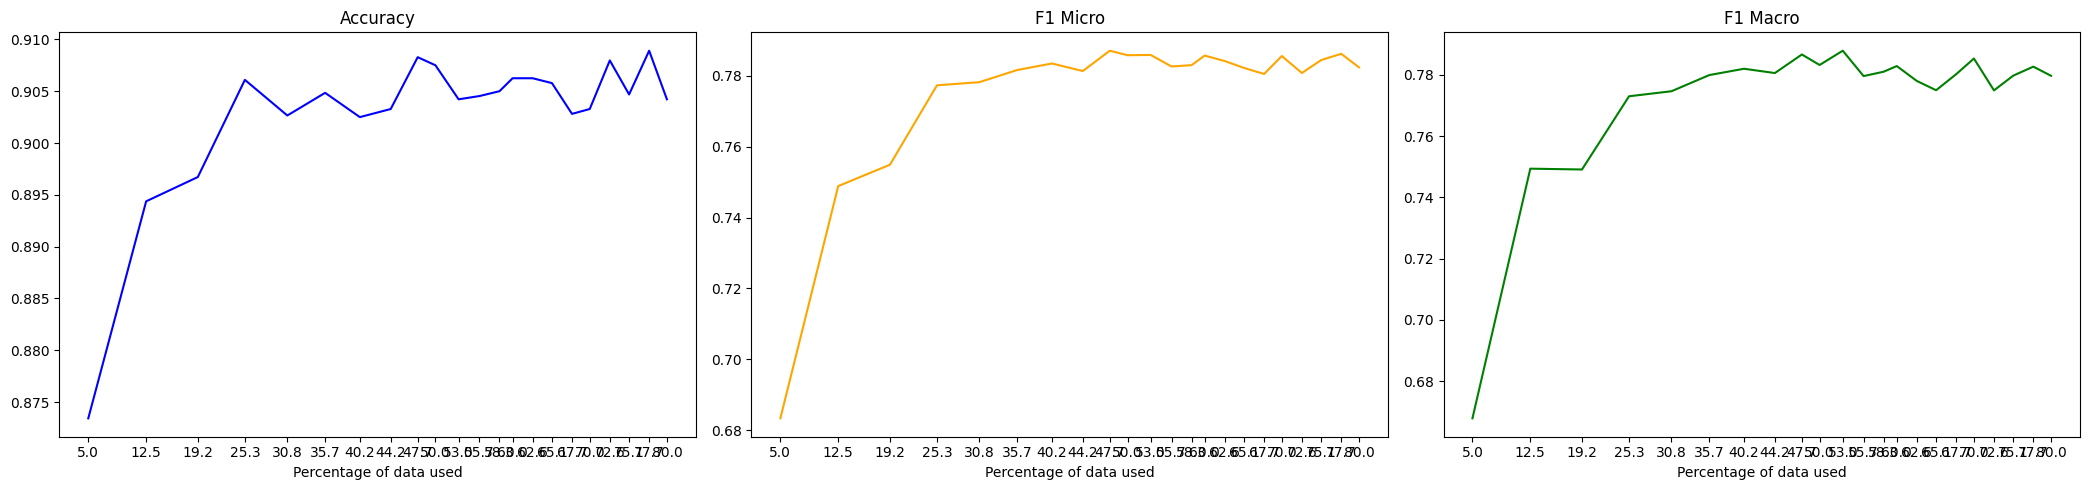

In [22]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5896, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4953, Accuracy: 0.79, F1 Micro: 0.0303, F1 Macro: 0.0269
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4288, Accuracy: 0.8306, F1 Micro: 0.3593, F1 Macro: 0.2395
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3915, Accuracy: 0.835, F1 Micro: 0.4413, F1 Macro: 0.3366
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3345, Accuracy: 0.8445, F1 Micro: 0.4826, F1 Macro: 0.381
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2887, Accuracy: 0.8612, F1 Micro: 0.6162, F1 Macro: 0.5481
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2536, Accuracy: 0.8698, F1 Micro: 0.6548, F1 Macro: 0.6311
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2078, Accuracy: 0.8711, F1 Micro: 0.6642, F1 Macro: 0.6388
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1918, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5683, Accuracy: 0.792, F1 Micro: 0.1799, F1 Macro: 0.1003
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4888, Accuracy: 0.8395, F1 Micro: 0.4603, F1 Macro: 0.3767
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4192, Accuracy: 0.8667, F1 Micro: 0.6231, F1 Macro: 0.564
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3459, Accuracy: 0.8798, F1 Micro: 0.691, F1 Macro: 0.683
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2973, Accuracy: 0.8811, F1 Micro: 0.6943, F1 Macro: 0.6794
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2349, Accuracy: 0.8859, F1 Micro: 0.7153, F1 Macro: 0.698
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1723, Accuracy: 0.8873, F1 Micro: 0.7473, F1 Macro: 0.7427
Epoch 8/10, Train Loss: 0.1481, Accuracy: 0.8869, F1 Micro: 0.7414, F1 Macro: 0.7349
Epoch 9/10, Train Loss: 0.1133, Accuracy: 0.8889, F1 Micro: 0.7434, F1 Macro: 0.7409
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.552, Accuracy: 0.8177, F1 Micro: 0.3388, F1 Macro: 0.2907
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4575, Accuracy: 0.8581, F1 Micro: 0.5842, F1 Macro: 0.5027
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.388, Accuracy: 0.8741, F1 Micro: 0.6644, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3218, Accuracy: 0.8863, F1 Micro: 0.7259, F1 Macro: 0.7242
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2605, Accuracy: 0.8916, F1 Micro: 0.7528, F1 Macro: 0.7508
Epoch 6/10, Train Loss: 0.1985, Accuracy: 0.8952, F1 Micro: 0.7475, F1 Macro: 0.7396
Epoch 7/10, Train Loss: 0.1675, Accuracy: 0.8953, F1 Micro: 0.7509, F1 Macro: 0.7441
Epoch 8/10, Train Loss: 0.1161, Accuracy: 0.8894, F1 Micro: 0.7514, F1 Macro: 0.7479
Epoch 9/10, Train Loss: 0.0901, Accuracy: 0.8902, F1 Micro: 0.7499, F1 Macro: 0.7469
Epoch 10/10, Train Loss: 0.0688, Accuracy: 0.8952, F1 Micro: 0.7523, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5408, Accuracy: 0.8455, F1 Micro: 0.5092, F1 Macro: 0.4309
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4278, Accuracy: 0.8761, F1 Micro: 0.6746, F1 Macro: 0.6507
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.365, Accuracy: 0.8902, F1 Micro: 0.7293, F1 Macro: 0.7206
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2936, Accuracy: 0.8952, F1 Micro: 0.7613, F1 Macro: 0.758
Epoch 5/10, Train Loss: 0.2378, Accuracy: 0.895, F1 Micro: 0.7371, F1 Macro: 0.7216
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1924, Accuracy: 0.8984, F1 Micro: 0.767, F1 Macro: 0.7632
Epoch 7/10, Train Loss: 0.1499, Accuracy: 0.8941, F1 Micro: 0.7633, F1 Macro: 0.7607
Epoch 8/10, Train Loss: 0.0998, Accuracy: 0.8997, F1 Micro: 0.7568, F1 Macro: 0.7457
Epoch 9/10, Train Loss: 0.0771, Accuracy: 0.8975, F1 Micro: 0.7604, F1 Macro: 0.7565
Epoch 10/10, Train Loss: 0.0646, Accuracy: 0.8913, F1 Micro: 0.7629, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5223, Accuracy: 0.855, F1 Micro: 0.5568, F1 Macro: 0.4831
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.414, Accuracy: 0.8869, F1 Micro: 0.7232, F1 Macro: 0.7166
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3471, Accuracy: 0.8933, F1 Micro: 0.7495, F1 Macro: 0.7387
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2898, Accuracy: 0.8955, F1 Micro: 0.7634, F1 Macro: 0.7581
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2232, Accuracy: 0.9019, F1 Micro: 0.7721, F1 Macro: 0.7664
Epoch 6/10, Train Loss: 0.1732, Accuracy: 0.9011, F1 Micro: 0.7653, F1 Macro: 0.7583
Epoch 7/10, Train Loss: 0.1275, Accuracy: 0.8959, F1 Micro: 0.7582, F1 Macro: 0.7509
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.097, Accuracy: 0.8977, F1 Micro: 0.7744, F1 Macro: 0.7743
Epoch 9/10, Train Loss: 0.0727, Accuracy: 0.8983, F1 Micro: 0.7715, F1 Macro: 0.7689
Epoch 10/10, Train Loss: 0.0616, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5116, Accuracy: 0.8517, F1 Micro: 0.5479, F1 Macro: 0.4795
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.407, Accuracy: 0.887, F1 Micro: 0.7466, F1 Macro: 0.743
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3344, Accuracy: 0.8981, F1 Micro: 0.7585, F1 Macro: 0.7507
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2739, Accuracy: 0.9011, F1 Micro: 0.7675, F1 Macro: 0.767
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2222, Accuracy: 0.9022, F1 Micro: 0.7719, F1 Macro: 0.7678
Epoch 6/10, Train Loss: 0.1659, Accuracy: 0.9014, F1 Micro: 0.7659, F1 Macro: 0.7609
Epoch 7/10, Train Loss: 0.1296, Accuracy: 0.9002, F1 Micro: 0.7568, F1 Macro: 0.7526
Epoch 8/10, Train Loss: 0.0932, Accuracy: 0.9016, F1 Micro: 0.7714, F1 Macro: 0.7682
Epoch 9/10, Train Loss: 0.0721, Accuracy: 0.9016, F1 Micro: 0.7635, F1 Macro: 0.7598
Epoch 10/10, Train Loss: 0.0537, Accuracy: 0.8992, F1 Micro: 0.7699, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5091, Accuracy: 0.8583, F1 Micro: 0.5887, F1 Macro: 0.517
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3911, Accuracy: 0.8923, F1 Micro: 0.7517, F1 Macro: 0.7462
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3174, Accuracy: 0.9014, F1 Micro: 0.7646, F1 Macro: 0.7641
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2684, Accuracy: 0.8986, F1 Micro: 0.7688, F1 Macro: 0.762
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.224, Accuracy: 0.8967, F1 Micro: 0.7749, F1 Macro: 0.7744
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1693, Accuracy: 0.9022, F1 Micro: 0.7755, F1 Macro: 0.7682
Epoch 7/10, Train Loss: 0.1241, Accuracy: 0.9014, F1 Micro: 0.7742, F1 Macro: 0.7676
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.096, Accuracy: 0.9052, F1 Micro: 0.7756, F1 Macro: 0.7706
Epoch 9/10, Train Loss: 0.0751, Accuracy: 0.9, F1 Micro: 0.7557, F1 Macro: 0.7481
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4922, Accuracy: 0.8683, F1 Micro: 0.6667, F1 Macro: 0.617
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3643, Accuracy: 0.8952, F1 Micro: 0.7412, F1 Macro: 0.7337
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3088, Accuracy: 0.898, F1 Micro: 0.7489, F1 Macro: 0.7493
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.26, Accuracy: 0.9025, F1 Micro: 0.7611, F1 Macro: 0.7517
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2091, Accuracy: 0.8995, F1 Micro: 0.7814, F1 Macro: 0.7802
Epoch 6/10, Train Loss: 0.1526, Accuracy: 0.9038, F1 Micro: 0.7722, F1 Macro: 0.7688
Epoch 7/10, Train Loss: 0.1237, Accuracy: 0.9022, F1 Micro: 0.771, F1 Macro: 0.768
Epoch 8/10, Train Loss: 0.0902, Accuracy: 0.9048, F1 Micro: 0.7763, F1 Macro: 0.7737
Epoch 9/10, Train Loss: 0.0703, Accuracy: 0.9036, F1 Micro: 0.7683, F1 Macro: 0.7657
Epoch 10/10, Train Loss: 0.0528, Accuracy: 0.9038, F1 Micro: 0.7775, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4793, Accuracy: 0.8803, F1 Micro: 0.7303, F1 Macro: 0.7248
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3558, Accuracy: 0.8909, F1 Micro: 0.7608, F1 Macro: 0.7592
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3072, Accuracy: 0.902, F1 Micro: 0.7687, F1 Macro: 0.7649
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.253, Accuracy: 0.9005, F1 Micro: 0.7792, F1 Macro: 0.775
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2051, Accuracy: 0.9039, F1 Micro: 0.7817, F1 Macro: 0.7791
Epoch 6/10, Train Loss: 0.1501, Accuracy: 0.9014, F1 Micro: 0.7706, F1 Macro: 0.765
Epoch 7/10, Train Loss: 0.107, Accuracy: 0.9011, F1 Micro: 0.7787, F1 Macro: 0.7764
Epoch 8/10, Train Loss: 0.0868, Accuracy: 0.9022, F1 Micro: 0.7614, F1 Macro: 0.7549
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0704, Accuracy: 0.9045, F1 Micro: 0.7826, F1 Macro: 0.7813
Epoch 10/10, Train Loss: 0.0525, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4748, Accuracy: 0.8627, F1 Micro: 0.584, F1 Macro: 0.5446
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3539, Accuracy: 0.8961, F1 Micro: 0.7542, F1 Macro: 0.7469
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2954, Accuracy: 0.9005, F1 Micro: 0.7761, F1 Macro: 0.7753
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2372, Accuracy: 0.9005, F1 Micro: 0.783, F1 Macro: 0.7817
Epoch 5/10, Train Loss: 0.1873, Accuracy: 0.9039, F1 Micro: 0.768, F1 Macro: 0.7588
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1437, Accuracy: 0.9072, F1 Micro: 0.7843, F1 Macro: 0.7804
Epoch 7/10, Train Loss: 0.1057, Accuracy: 0.9034, F1 Micro: 0.7677, F1 Macro: 0.7624
Epoch 8/10, Train Loss: 0.0848, Accuracy: 0.9042, F1 Micro: 0.7741, F1 Macro: 0.773
Epoch 9/10, Train Loss: 0.0597, Accuracy: 0.9041, F1 Micro: 0.7672, F1 Macro: 0.7612
Epoch 10/10, Train Loss: 0.0491, Accuracy: 0.9052, F1 Micro: 0.7702, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4596, Accuracy: 0.8802, F1 Micro: 0.7173, F1 Macro: 0.7134
Epoch 2/10, Train Loss: 0.3369, Accuracy: 0.8914, F1 Micro: 0.7059, F1 Macro: 0.6845
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2842, Accuracy: 0.8995, F1 Micro: 0.7445, F1 Macro: 0.7281
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2424, Accuracy: 0.9039, F1 Micro: 0.7852, F1 Macro: 0.7825
Epoch 5/10, Train Loss: 0.1857, Accuracy: 0.9056, F1 Micro: 0.7813, F1 Macro: 0.7745
Epoch 6/10, Train Loss: 0.1422, Accuracy: 0.9009, F1 Micro: 0.7721, F1 Macro: 0.7662
Epoch 7/10, Train Loss: 0.1099, Accuracy: 0.9017, F1 Micro: 0.764, F1 Macro: 0.7562
Epoch 8/10, Train Loss: 0.0806, Accuracy: 0.9019, F1 Micro: 0.7686, F1 Macro: 0.7583
Epoch 9/10, Train Loss: 0.0624, Accuracy: 0.9034, F1 Micro: 0.7799, F1 Macro: 0.7784
Epoch 10/10, Train Loss: 0.0526, Accuracy: 0.9019, F1 Micro: 0.7616, F1 Macro: 0.7512

 Iteration 4120: Accuracy: 0.9039, F1 Micro: 0.785

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4543, Accuracy: 0.8867, F1 Micro: 0.7399, F1 Macro: 0.7349
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3267, Accuracy: 0.8997, F1 Micro: 0.7679, F1 Macro: 0.7611
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2795, Accuracy: 0.9042, F1 Micro: 0.7772, F1 Macro: 0.7711
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2262, Accuracy: 0.9048, F1 Micro: 0.7835, F1 Macro: 0.7763
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1832, Accuracy: 0.8994, F1 Micro: 0.7859, F1 Macro: 0.7861
Epoch 6/10, Train Loss: 0.1432, Accuracy: 0.9038, F1 Micro: 0.7803, F1 Macro: 0.7781
Epoch 7/10, Train Loss: 0.1001, Accuracy: 0.9055, F1 Micro: 0.7846, F1 Macro: 0.78
Epoch 8/10, Train Loss: 0.0778, Accuracy: 0.9017, F1 Micro: 0.7764, F1 Macro: 0.77
Epoch 9/10, Train Loss: 0.0668, Accuracy: 0.9016, F1 Micro: 0.7712, F1 Macro: 0.7683
Epoch 10/10, Train Loss: 0.0478, Accuracy: 0.9027, F1 Micro: 0.774, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4409, Accuracy: 0.8773, F1 Micro: 0.7128, F1 Macro: 0.6989
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3084, Accuracy: 0.8994, F1 Micro: 0.7561, F1 Macro: 0.7456
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2656, Accuracy: 0.9028, F1 Micro: 0.7667, F1 Macro: 0.76
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2165, Accuracy: 0.9045, F1 Micro: 0.7855, F1 Macro: 0.7777
Epoch 5/10, Train Loss: 0.171, Accuracy: 0.9059, F1 Micro: 0.776, F1 Macro: 0.765
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1361, Accuracy: 0.903, F1 Micro: 0.7875, F1 Macro: 0.7851
Epoch 7/10, Train Loss: 0.0998, Accuracy: 0.9058, F1 Micro: 0.7779, F1 Macro: 0.7744
Epoch 8/10, Train Loss: 0.0735, Accuracy: 0.898, F1 Micro: 0.776, F1 Macro: 0.7721
Epoch 9/10, Train Loss: 0.0573, Accuracy: 0.9045, F1 Micro: 0.7795, F1 Macro: 0.7736
Epoch 10/10, Train Loss: 0.0448, Accuracy: 0.9031, F1 Micro: 0.7798, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4234, Accuracy: 0.8797, F1 Micro: 0.6729, F1 Macro: 0.6567
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3086, Accuracy: 0.8964, F1 Micro: 0.7554, F1 Macro: 0.747
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2554, Accuracy: 0.9058, F1 Micro: 0.7794, F1 Macro: 0.7686
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2082, Accuracy: 0.9031, F1 Micro: 0.7803, F1 Macro: 0.7767
Epoch 5/10, Train Loss: 0.1547, Accuracy: 0.9059, F1 Micro: 0.78, F1 Macro: 0.7748
Epoch 6/10, Train Loss: 0.1181, Accuracy: 0.9055, F1 Micro: 0.7791, F1 Macro: 0.7753
Epoch 7/10, Train Loss: 0.0944, Accuracy: 0.9, F1 Micro: 0.7776, F1 Macro: 0.7734
Epoch 8/10, Train Loss: 0.0733, Accuracy: 0.9055, F1 Micro: 0.7798, F1 Macro: 0.7757
Epoch 9/10, Train Loss: 0.0527, Accuracy: 0.9008, F1 Micro: 0.779, F1 Macro: 0.7772
Epoch 10/10, Train Loss: 0.0406, Accuracy: 0.903, F1 Micro: 0.777, F1 Macro: 0.7736

 Iteration 4663: Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.436, Accuracy: 0.8841, F1 Micro: 0.7157, F1 Macro: 0.7161
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3073, Accuracy: 0.8966, F1 Micro: 0.7492, F1 Macro: 0.7365
Epoch 3/10, Train Loss: 0.249, Accuracy: 0.8995, F1 Micro: 0.7435, F1 Macro: 0.7428
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2028, Accuracy: 0.9077, F1 Micro: 0.7826, F1 Macro: 0.7756
Epoch 5/10, Train Loss: 0.1594, Accuracy: 0.9006, F1 Micro: 0.7707, F1 Macro: 0.7638
Epoch 6/10, Train Loss: 0.1203, Accuracy: 0.9017, F1 Micro: 0.7783, F1 Macro: 0.7784
Epoch 7/10, Train Loss: 0.0916, Accuracy: 0.9052, F1 Micro: 0.7751, F1 Macro: 0.7706
Epoch 8/10, Train Loss: 0.0678, Accuracy: 0.9017, F1 Micro: 0.7798, F1 Macro: 0.7756
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.05, Accuracy: 0.9053, F1 Micro: 0.7856, F1 Macro: 0.7808
Epoch 10/10, Train Loss: 0.0443, Accuracy: 0.9067, F1 Micro: 0.7841, F1 Macro: 0.7797

 Iteration 4863: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4151, Accuracy: 0.8869, F1 Micro: 0.734, F1 Macro: 0.7289
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2818, Accuracy: 0.8998, F1 Micro: 0.7716, F1 Macro: 0.7641
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2379, Accuracy: 0.9014, F1 Micro: 0.7825, F1 Macro: 0.7798
Epoch 4/10, Train Loss: 0.1919, Accuracy: 0.9022, F1 Micro: 0.782, F1 Macro: 0.778
Epoch 5/10, Train Loss: 0.1563, Accuracy: 0.9053, F1 Micro: 0.774, F1 Macro: 0.7697
Epoch 6/10, Train Loss: 0.1112, Accuracy: 0.9033, F1 Micro: 0.7698, F1 Macro: 0.7624
Epoch 7/10, Train Loss: 0.0863, Accuracy: 0.905, F1 Micro: 0.7669, F1 Macro: 0.7535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0701, Accuracy: 0.9073, F1 Micro: 0.7871, F1 Macro: 0.7821
Epoch 9/10, Train Loss: 0.051, Accuracy: 0.9073, F1 Micro: 0.7813, F1 Macro: 0.7748
Epoch 10/10, Train Loss: 0.0383, Accuracy: 0.9056, F1 Micro: 0.7648, F1 Macro: 0.7584

 Iteration 5063: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4042, Accuracy: 0.8898, F1 Micro: 0.739, F1 Macro: 0.7305
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2757, Accuracy: 0.9025, F1 Micro: 0.7754, F1 Macro: 0.7689
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2239, Accuracy: 0.9047, F1 Micro: 0.7791, F1 Macro: 0.7748
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1816, Accuracy: 0.9016, F1 Micro: 0.7819, F1 Macro: 0.7789
Epoch 5/10, Train Loss: 0.1508, Accuracy: 0.9078, F1 Micro: 0.7779, F1 Macro: 0.7741
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1141, Accuracy: 0.9075, F1 Micro: 0.785, F1 Macro: 0.7799
Epoch 7/10, Train Loss: 0.0855, Accuracy: 0.9064, F1 Micro: 0.7792, F1 Macro: 0.7735
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0578, Accuracy: 0.9058, F1 Micro: 0.7897, F1 Macro: 0.7877
Epoch 9/10, Train Loss: 0.0461, Accuracy: 0.9045, F1 Micro: 0.7849, F1 Macro: 0.781
Epoch 10/10, Train Loss: 0.0386, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3917, Accuracy: 0.8855, F1 Micro: 0.7156, F1 Macro: 0.7159
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2663, Accuracy: 0.8981, F1 Micro: 0.7477, F1 Macro: 0.7389
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2213, Accuracy: 0.9044, F1 Micro: 0.7765, F1 Macro: 0.7685
Epoch 4/10, Train Loss: 0.1768, Accuracy: 0.9016, F1 Micro: 0.7694, F1 Macro: 0.7649
Epoch 5/10, Train Loss: 0.1369, Accuracy: 0.8972, F1 Micro: 0.7696, F1 Macro: 0.7635
Epoch 6/10, Train Loss: 0.1, Accuracy: 0.9022, F1 Micro: 0.765, F1 Macro: 0.7586
Epoch 7/10, Train Loss: 0.0754, Accuracy: 0.902, F1 Micro: 0.7722, F1 Macro: 0.7685
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.062, Accuracy: 0.902, F1 Micro: 0.7812, F1 Macro: 0.7813
Epoch 9/10, Train Loss: 0.0466, Accuracy: 0.8991, F1 Micro: 0.7791, F1 Macro: 0.7802
Epoch 10/10, Train Loss: 0.0382, Accuracy: 0.9006, F1 Micro: 0.7741, F1 Macro: 0.7702

 Iteration 5441: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3795, Accuracy: 0.8906, F1 Micro: 0.7242, F1 Macro: 0.7172
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2609, Accuracy: 0.9022, F1 Micro: 0.7568, F1 Macro: 0.7467
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2107, Accuracy: 0.9034, F1 Micro: 0.7764, F1 Macro: 0.7732
Epoch 4/10, Train Loss: 0.1805, Accuracy: 0.9041, F1 Micro: 0.7711, F1 Macro: 0.7669
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1341, Accuracy: 0.9023, F1 Micro: 0.7862, F1 Macro: 0.7841
Epoch 6/10, Train Loss: 0.1011, Accuracy: 0.9028, F1 Micro: 0.7735, F1 Macro: 0.7706
Epoch 7/10, Train Loss: 0.0728, Accuracy: 0.9077, F1 Micro: 0.7789, F1 Macro: 0.7756
Epoch 8/10, Train Loss: 0.0572, Accuracy: 0.9048, F1 Micro: 0.7759, F1 Macro: 0.7706
Epoch 9/10, Train Loss: 0.0395, Accuracy: 0.9062, F1 Micro: 0.7786, F1 Macro: 0.777
Epoch 10/10, Train Loss: 0.0316, Accuracy: 0.8992, F1 Micro: 0.7786, F1 Macro: 0.7762

 Iteration 5641: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3733, Accuracy: 0.8884, F1 Micro: 0.7324, F1 Macro: 0.7185
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2505, Accuracy: 0.9014, F1 Micro: 0.755, F1 Macro: 0.7516
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2064, Accuracy: 0.9045, F1 Micro: 0.7758, F1 Macro: 0.7716
Epoch 4/10, Train Loss: 0.1665, Accuracy: 0.9058, F1 Micro: 0.7747, F1 Macro: 0.7666
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1317, Accuracy: 0.9047, F1 Micro: 0.7772, F1 Macro: 0.7718
Epoch 6/10, Train Loss: 0.094, Accuracy: 0.8955, F1 Micro: 0.7747, F1 Macro: 0.7767
Epoch 7/10, Train Loss: 0.0722, Accuracy: 0.9027, F1 Micro: 0.7734, F1 Macro: 0.7684
Epoch 8/10, Train Loss: 0.0517, Accuracy: 0.9041, F1 Micro: 0.766, F1 Macro: 0.757
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0422, Accuracy: 0.9047, F1 Micro: 0.7804, F1 Macro: 0.7786
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0317, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3759, Accuracy: 0.887, F1 Micro: 0.7088, F1 Macro: 0.7003
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2428, Accuracy: 0.8973, F1 Micro: 0.7559, F1 Macro: 0.7452
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2066, Accuracy: 0.9036, F1 Micro: 0.776, F1 Macro: 0.7719
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1643, Accuracy: 0.905, F1 Micro: 0.785, F1 Macro: 0.7822
Epoch 5/10, Train Loss: 0.1288, Accuracy: 0.8936, F1 Micro: 0.7761, F1 Macro: 0.7796
Epoch 6/10, Train Loss: 0.0928, Accuracy: 0.9027, F1 Micro: 0.775, F1 Macro: 0.7728
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0702, Accuracy: 0.9077, F1 Micro: 0.7866, F1 Macro: 0.783
Epoch 8/10, Train Loss: 0.0513, Accuracy: 0.9023, F1 Micro: 0.7823, F1 Macro: 0.7805
Epoch 9/10, Train Loss: 0.0396, Accuracy: 0.9041, F1 Micro: 0.7812, F1 Macro: 0.7788
Epoch 10/10, Train Loss: 0.0331, Accuracy: 0.9045, F1 Micro: 0.7674, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3536, Accuracy: 0.8833, F1 Micro: 0.686, F1 Macro: 0.6658
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2349, Accuracy: 0.9019, F1 Micro: 0.7636, F1 Macro: 0.7532
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1972, Accuracy: 0.9028, F1 Micro: 0.7677, F1 Macro: 0.764
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1571, Accuracy: 0.9077, F1 Micro: 0.7853, F1 Macro: 0.7794
Epoch 5/10, Train Loss: 0.1134, Accuracy: 0.9062, F1 Micro: 0.7812, F1 Macro: 0.7749
Epoch 6/10, Train Loss: 0.0856, Accuracy: 0.9011, F1 Micro: 0.7551, F1 Macro: 0.7406
Epoch 7/10, Train Loss: 0.0607, Accuracy: 0.9041, F1 Micro: 0.7695, F1 Macro: 0.7688
Epoch 8/10, Train Loss: 0.0467, Accuracy: 0.9053, F1 Micro: 0.7779, F1 Macro: 0.7719
Epoch 9/10, Train Loss: 0.0361, Accuracy: 0.9042, F1 Micro: 0.7732, F1 Macro: 0.7691
Epoch 10/10, Train Loss: 0.0278, Accuracy: 0.9017, F1 Micro: 0.7692, F1 Macro: 0.7671

 Iteration 6218: A

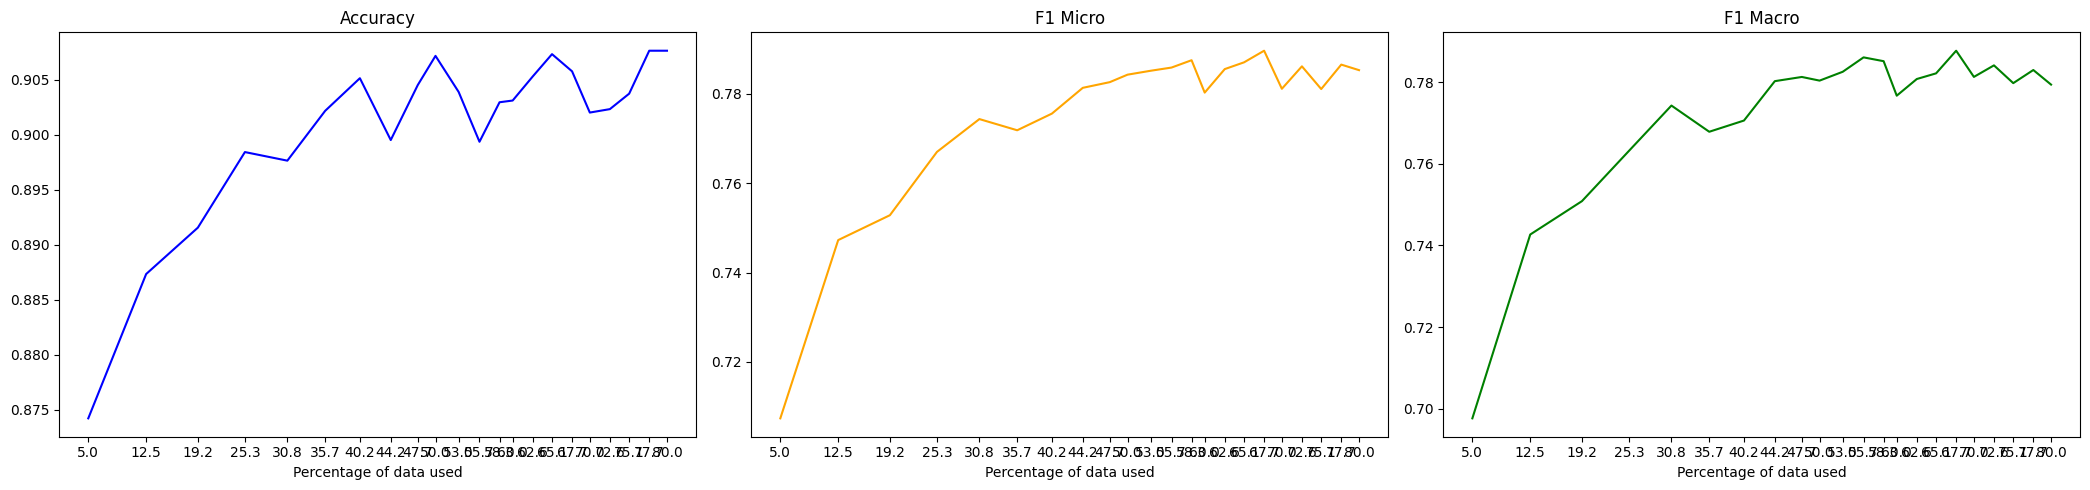

In [23]:
active_learning(seeds[4], 4)